In [1]:
import time
import sys
import os
import stable_baselines3
import gymnasium as gym
import numpy as np
import jsbsim
from gymnasium import spaces
import math

print("Gym version:", gym.__version__)
print("Stable-Baselines3 version:", stable_baselines3.__version__)
print("JSBSim installed successfully!")

2025-03-16 21:55:03.719438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742187303.776370     596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742187303.792345     596 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 21:55:03.929663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Gym version: 1.0.0
Stable-Baselines3 version: 2.5.0
JSBSim installed successfully!


In [ ]:
sim_ownship = jsbsim.FGFDMExec("/home/sezhou/aienv/lib/python3.10/site-packages/jsbsim")
sim_ownship.load_model("f16")

In [ ]:
sim_target = jsbsim.FGFDMExec("/home/sezhou/aienv/lib/python3.10/site-packages/jsbsim")
sim_target.load_model("f16")

In [4]:
print(sim_ownship.query_property_catalog("phi-deg"))

attitude/phi-deg (R)
ic/phi-deg (RW)



In [29]:
def roll_correction_cmd(desired_roll, current_roll, k_roll=0.05):
    # keeps roll at desired level
    roll_error = desired_roll - current_roll
    # Apply a proportional control to keep roll stable
    roll_cmd = np.clip(roll_error * k_roll, -1.0, 1.0)
    return roll_cmd

def haversine(lat1, lon1, lat2, lon2):
    """Compute approximate distance (in meters) between two lat-long points."""
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in meters

def angular_difference(new_angle, old_angle):
    """Compute the smallest difference between two angles, handling wraparound at ±180°."""
    return ((new_angle - old_angle + 180) % 360) - 180

class F16LeadPursuitEnv(gym.Env):
    def __init__(self, stabilize_roll=True):
        super(F16LeadPursuitEnv, self).__init__()

        # ✅ Use preloaded JSBSim models instead of reloading them
        self.sim_ownship = sim_ownship
        self.sim_target = sim_target

        # throttle (0 ~ 1), pitch (-1 ~ 0) (not permitting pitch down for now to help agent learn)
        self.action_space = spaces.Box(
            low=np.array([0, -1]),
            high=np.array([1, 0]),
            dtype=np.float32
        )

        # distance (0 ~ 2000 m)
        # aon (target angle off nose) (-180 ~ 180 deg)
        # closure (-500 ~ 500 m/s)
        # aon_roc (-360 ~ 360 deg/s)
        # aspect (0 ~ 180 deg)
        # aspect_roc (-180 ~ 180 deg/s)
        # own_speed (0, 2000 ft/s)
        # own_g (-15, 15 g)
        self.observation_space = spaces.Box(low=np.array([0, -180, -500, -360, 0, -180, 0, -15]), 
                                            high=np.array([5000, 180, 500, 360, 180, 180, 2000, 15]), 
                                            dtype=np.float32)
        self.steps = 0
        self.stabilize_roll = stabilize_roll

    def reset(self, seed=None, options=None):
        """Reset the environment and reset both aircraft."""
        super().reset(seed=seed)  

        self.sim_ownship.reset_to_initial_conditions(0)
        self.sim_target.reset_to_initial_conditions(0)

        print("Setting initial conditions for both aircraft...")

        # Set initial velocity (Mach 0.8 ~ 896 ft/s)
        self.sim_ownship["ic/vt-fps"] = 900
        self.sim_target["ic/vt-fps"] = 900

        # ✅ Use precise positioning via JSBSim's coordinate frame
        self.sim_ownship["ic/lat-gc-deg"] = 0.0  # Equator for simplicity
        self.sim_ownship["ic/long-gc-deg"] = 0.0  # Reference point
        self.sim_ownship["ic/h-sl-ft"] = 30000  

        # ✅ Correctly offset target aircraft using meters per degree latitude (~111km)
        self.sim_target["ic/lat-gc-deg"] = 2000.0 / 111000.0  # 2000m ahead
        self.sim_target["ic/long-gc-deg"] = 0.0
        self.sim_target["ic/h-sl-ft"] = 30000  

        # Set aircraft orientation (Level flight)
        self.desired_roll = 90  # roll angle
        self.sim_ownship["ic/theta-deg"] = 0.0
        self.sim_ownship["ic/phi-deg"] = self.desired_roll
        self.sim_ownship["ic/psi-true-deg"] = 0.0

        self.sim_target["ic/theta-deg"] = 0.0
        self.sim_target["ic/phi-deg"] = self.desired_roll
        self.sim_target["ic/psi-true-deg"] = 0.0

         # ✅ Ensure engine is properly started
        self.sim_ownship["propulsion/cutoff_cmd"] = 0  # ✅ Allow fuel
        self.sim_ownship["propulsion/starter_cmd"] = 1  # ✅ Start engine
        self.sim_ownship["propulsion/engine/set-running"] = 1  # ✅ Ensure running
        self.sim_ownship["fcs/throttle-cmd-norm"] = 0.7  # ✅ Apply throttle for startup
    
        # ✅ Repeat for target aircraft if needed
        self.sim_target["propulsion/cutoff_cmd"] = 0
        self.sim_target["propulsion/starter_cmd"] = 1
        self.sim_target["propulsion/engine/set-running"] = 1
        self.sim_target["fcs/throttle-cmd-norm"] = 0.7  

        #stick
        self.sim_ownship["fcs/elevator-cmd-norm"] = -0.05
        self.sim_target["fcs/elevator-cmd-norm"] = -0.8 # target pulls and turns right
        self.sim_ownship["fcs/aileron-cmd-norm"] = 0.0
        self.sim_target["fcs/aileron-cmd-norm"] = 0.0

        # Run initial conditions
        self.sim_ownship.run_ic()
        self.sim_target.run_ic()

        print("Initial conditions set. Starting simulation...")
        self.sim_ownship.run()
        self.sim_target.run()

        self.steps = 0
        self.prev_aon = 0.0
        self.prev_aspect = 0.0
        self.prev_throttle = 0.7
        self.prev_pitch = -0.05

        return self._get_obs(), {}

    def step(self, action):
        """Step the environment forward."""
        throttle = np.clip(action[0], 0.0, 1.0)
        pitch = np.clip(action[1], -1.0, 1.0)
        self.sim_ownship["fcs/throttle-cmd-norm"] = throttle
        self.sim_ownship["fcs/elevator-cmd-norm"] = pitch

        # Need to correct roll so the aircraft stays relatively level (phi-deg is roll)
        if self.stabilize_roll:
            self.sim_ownship["fcs/aileron-cmd-norm"] = roll_correction_cmd(self.desired_roll, self.sim_ownship["attitude/phi-deg"])
            self.sim_target["fcs/aileron-cmd-norm"] = roll_correction_cmd(self.desired_roll, self.sim_target["attitude/phi-deg"])

        # step simulation
        self.sim_ownship.run()
        self.sim_target.run()

        obs = self._get_obs()

        distance, aon, closure, aon_roc, aspect, aspect_roc, own_speed, own_g = obs

        # Reward weights (These should be fine-tuned)
        k1, k2, k3, k4 = 1.0, 0.5, 0.05, 1.5
        k5, k6, k7, k8 = 0.8, 0.3, 0.01, 0.01
        k9, k10 = 2.0, 2.0
        d_ideal = 300  # Ideal distance (meters)
        aspect_high = 90  # Maximum acceptable aspect before penalty
        aon_low = -20  # Threshold for overleading
    
        # 1. Reward for closing distance and staying near ideal
        d_start = 2000  # Initial distance
        distance_reward = k1 * (d_start - distance) / 2000 - k2 * abs(distance - d_ideal) / 2000
    
        # 2. Penalize excessive (negative, i.e. closing in) closure when within ideal distance
        closure_penalty = k3 * max(0, d_ideal - distance) * min(0, closure) / 2500
    
        # 3. Exponential bonus for maintaining ideal distance
        a = 0.01  # Scaling factor for smooth transition
        aspect_cosine = max(0, np.cos(np.radians(aspect))) # no reward if aspect is wrong, i.e. ownship is not behind target
        ideal_distance_bonus = k4 * np.exp(-a * abs(distance - d_ideal)) * aspect_cosine
    
        # Dynamic Aspect penalty
        effective_distance = max(distance, 100)  # avoid divide-by-zero
        aspect_penalty = -k5 * abs(aspect) * 2000 / (180 * effective_distance)
        
        # Dynamic AON penalty
        aon_penalty = -k6 * abs(aon) * 2000 / (180 * effective_distance)

        # Smoothness penalty
        smoothness_penalty = -k7 * abs(throttle - self.prev_throttle) - k8 * abs(pitch - self.prev_pitch)
        self.prev_throttle = throttle
        self.prev_pitch = pitch

        # Bonus
        bonus = 0
        if abs(aspect) < 30 and 500 < distance < 800:
            bonus += k9
        if abs(aon) < 10 and 500 < distance < 800:
            bonus += k10
    
        # Total reward (clamped to (-1,1))
        reward = (
            distance_reward + closure_penalty + ideal_distance_bonus +
            aspect_penalty + aon_penalty+ smoothness_penalty
        )
    
        self.steps += 1
        done = self.steps > 5000
        truncated = False

        return obs, reward, done, truncated, {}

    def _get_obs(self):
        """Retrieve the latest observations from JSBSim."""
        
        # 1. Distance Calculation (approximate using Haversine)
        lat_own = self.sim_ownship["position/lat-gc-deg"]
        lon_own = self.sim_ownship["position/long-gc-deg"]
        lat_tgt = self.sim_target["position/lat-gc-deg"]
        lon_tgt = self.sim_target["position/long-gc-deg"]
        
        distance = haversine(lat_own, lon_own, lat_tgt, lon_tgt)
        
        # 2. Line-of-Sight (LOS) Angle
        los_angle = math.degrees(math.atan2(lat_tgt - lat_own, lon_tgt - lon_own)) % 360  # LOS in degrees
        los_angle = (450 - los_angle) % 360  # Convert to JSBSim’s heading system (0 north, 90 east) so we can diff with aircraft heading

        # 3. AON (Angle Off Nose)
        own_heading = self.sim_ownship["attitude/psi-deg"] % 360
        aon = ((los_angle - own_heading + 180) % 360) - 180  # Normalize to [-180, 180]

        # 4. Closure Rate
        speed_own = self.sim_ownship["velocities/vtrue-fps"]
        speed_tgt = self.sim_target["velocities/vtrue-fps"]
        
        heading_own = self.sim_ownship["attitude/psi-deg"] % 360
        heading_tgt = self.sim_target["attitude/psi-deg"] % 360

        # Compute closure rate along the LOS
        closure = (speed_tgt * math.cos(math.radians(heading_tgt - los_angle))) - \
                  (speed_own * math.cos(math.radians(heading_own - los_angle)))

        # 5. AON Rate of Change (Derivative)
        aon_diff = angular_difference(aon, getattr(self, "prev_aon", aon))
        aon_roc = aon_diff / 0.00833  # dt = 0.00833s (120Hz)
        self.prev_aon = aon

        # 6. Aspect Angle
        target_heading = self.sim_target["attitude/psi-deg"] % 360
        aspect = ((target_heading - los_angle + 180) % 360) - 180  # Normalize to [-180, 180]

        # 7. Aspect Rate of Change (Derivative)
        aspect_diff = angular_difference(aspect, getattr(self, "prev_aspect", aspect))
        aspect_roc = aspect_diff / 0.00833
        self.prev_aspect = aspect

        # 8. Own Speed
        own_speed = speed_own  # Directly from JSBSim

        # 9. Own G-Force
        own_g = self.sim_ownship["accelerations/Nz"]

        # Return normalized observations
        obs = np.array([
            distance,
            aon,
            closure,
            aon_roc,
            aspect,
            aspect_roc,
            own_speed,
            own_g
        ], dtype=np.float32)

        return obs
        

    def render(self, mode="human"):
        # TODO
        print("")

    def close(self):
        self.sim_ownship = None
        self.sim_target = None


In [36]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
import os

# Setup directory to save models
checkpoint_dir = "./f16_leadpursuit_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Save every 100,000 steps (5 checkpoints over 500,000 steps)
checkpoint_callback = CheckpointCallback(
    save_freq=50000,
    save_path=checkpoint_dir,
    name_prefix="f16_lead_pursuit_after_150k_no_fcs"
)

In [37]:
# Wrap your environment with Monitor (for logging)
env_no_fcs = Monitor(F16LeadPursuitEnv(stabilize_roll=False))
env_with_fcs = Monitor(F16LeadPursuitEnv())

In [ ]:
model = PPO(
    "MlpPolicy",  # Simple Multi-Layer Perceptron policy
    env_no_fcs,
    verbose=1,
    tensorboard_log="./ppo_logs",  # Optional: for tensorboard
    learning_rate=3e-4,            # Tweak if needed
    batch_size=2048,               # Large batch, stable for continuous tasks
)

print("Starting training: 250k steps WITHOUT FCS...")
model.learn(total_timesteps=250000, callback=checkpoint_callback, reset_num_timesteps=False)

# 4. Switch to FCS-enabled environment
print("Switching to environment WITH roll stabilization...")
model.set_env(env_with_fcs)

print("Continuing training: 250k steps WITH FCS...")
model.learn(total_timesteps=250000, callback=checkpoint_callback, reset_num_timesteps=False)

# 5. Save final model
model.save("f16_lead_pursuit_final_250k_no_fcs_250k_with_fcs")
print("Training complete. Final model saved.")


In [ ]:
# Load unstabilized checkpoint 3
model = PPO.load("./f16_leadpursuit_checkpoints/f16_lead_pursuit_250k_no_fcs_250k_with_fcs_150000_steps", env=env_with_fcs)
print("Continuing training: 100k steps WITH FCS...")
model.learn(total_timesteps=100000, callback=checkpoint_callback, reset_num_timesteps=False)

In [33]:
# Validate environment and observation by stepping 5000 steps and observing metrics
import numpy as np
import matplotlib.pyplot as plt

def testEnvironment(model_path="", fixed_action=None, time_in_seconds=False):
    # Initialize the environment
    model = None
    action = None
    if model_path:
        model = PPO.load(model_path)
        print("loaded model: ", model_path)
    elif fixed_action is not None:
        action = fixed_action
        print(f"using fixed action for throttle {action[0]} and pitch {action[1]}")
    else:
        print("please provide model path or a fixed action np array!")
        return
    
    env = F16LeadPursuitEnv()
    obs = env.reset()[0]  # Get initial observation
    print("initial observation", obs)
    
    # Storage for plotting
    timesteps = 4000
    data = {  # Stores observations over time
        "reward": [],
        "distance": [],
        "aon": [],
        "closure": [],
        "aon_roc": [],
        "aspect": [],
        "aspect_roc": [],
        "own_speed": [],
        "own_g": [],
        "own_alt": [],
        "own_roll": [],
        "throttle": [],
        "pitch": [],
        "own_x": [],  # X position (meters)
        "own_y": [],  # Y position (meters)
        "tgt_x": [],  # Target X position (meters)
        "tgt_y": [],   # Target Y position (meters)
        "own_heading": [], # Store headings for visualization
        "tgt_heading": []
        
    }
    
    lat0, lon0 = env.sim_ownship["position/lat-gc-deg"], env.sim_ownship["position/long-gc-deg"]  # Initial lat/lon
    # Approximate conversion factors (varies slightly with latitude)
    meters_per_degree_lat = 111000  # 1 degree latitude ≈ 111 km
    meters_per_degree_lon = lambda lat: 111000 * np.cos(np.radians(lat))  # Adjust for Earth's curvature
    
    total_reward = 0
    
    
    # Run for steps
    for _ in range(timesteps):
        if model:
            action, _states = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)  # Step env
        if done: break  # Stop if simulation ends
        
        # Store each observation
        data["reward"].append(reward)
        data["distance"].append(obs[0])
        data["aon"].append(obs[1])
        data["closure"].append(obs[2])
        data["aon_roc"].append(obs[3])
        data["aspect"].append(obs[4])
        data["aspect_roc"].append(obs[5])
        data["own_speed"].append(obs[6])
        data["own_g"].append(obs[7])
        data["own_alt"].append(env.sim_ownship["position/h-sl-ft"])
        data["throttle"].append(action[0])
        data["pitch"].append(action[1])
        data["own_roll"].append(env.sim_ownship["attitude/phi-deg"])

        # Compute ownship position in meters from start position
        lat_own = env.sim_ownship["position/lat-gc-deg"]
        lon_own = env.sim_ownship["position/long-gc-deg"]
        lat_tgt = env.sim_target["position/lat-gc-deg"]
        lon_tgt = env.sim_target["position/long-gc-deg"]

        # Convert lat/lon deviation to meters relative to initial position
        own_x = (lon_own - lon0) * meters_per_degree_lon(lat0)
        own_y = (lat_own - lat0) * meters_per_degree_lat
        tgt_x = (lon_tgt - lon0) * meters_per_degree_lon(lat0)
        tgt_y = (lat_tgt - lat0) * meters_per_degree_lat

        data["own_x"].append(own_x)
        data["own_y"].append(own_y)
        data["tgt_x"].append(tgt_x)
        data["tgt_y"].append(tgt_y)

        # Store corrected aircraft headings
        own_heading_jsbsim = env.sim_ownship["attitude/psi-deg"]
        tgt_heading_jsbsim = env.sim_target["attitude/psi-deg"]
        data["own_heading"].append((450 - own_heading_jsbsim) % 360)  
        data["tgt_heading"].append((450 - tgt_heading_jsbsim) % 360)  

        total_reward += reward
    
    # Close environment
    env.close()

    # Setup time axis
    x_axis_label = "Timestep"
    x_values = np.arange(len(data["distance"]))  # Default to timesteps
    if time_in_seconds:
        x_axis_label = "Time (seconds)"
        x_values = x_values * 0.00833  # Convert to seconds
    
    # Plot results
    fig, axes = plt.subplots(7, 2, figsize=(12, 12))
    if model:
        fig.suptitle(f"F-16 Lead Pursuit RL Environment Validation for {model_path}, total reward: {total_reward}", fontsize=14)
    else:
        fig.suptitle(f"F-16 Lead Pursuit RL Environment Validation for {action[0]} throttle and {action[1]} pitch, total reward: {total_reward}", fontsize=14)
    
    metrics = list(data.keys())
    # Iterate over subplots and plot data
    for i, ax in enumerate(axes.flat):
        if i < len(metrics):  # Ensure we don't exceed the metric count
            ax.plot(x_values, data[metrics[i]], label=metrics[i])
            ax.set_title(metrics[i])
            ax.set_xlabel(x_axis_label)
            ax.set_ylabel(metrics[i])
            ax.legend()
        else:
            ax.axis("off")  # Hide extra empty plots
    
    plt.tight_layout()
    plt.show()

    # **NEW: Top-down position graph**
    plt.figure(figsize=(8, 8))
    plt.plot(data["own_x"], data["own_y"], label="Ownship", color="blue")
    plt.plot(data["tgt_x"], data["tgt_y"], label="Target", color="red", linestyle="dashed")
    plt.scatter([0], [0], color="blue", marker="o", label="Ownship Start")  # Ownship starts at (0,0)
    plt.scatter([data["tgt_x"][0]], [data["tgt_y"][0]], color="red", marker="x", label="Target Start")

    # **Mark every 10% step in the trajectory**
    num_steps = len(data["own_x"])
    step_interval = num_steps // 10  # 10% intervals
    for i in range(0, num_steps, step_interval):
        plt.scatter(data["own_x"][i], data["own_y"][i], color="blue", marker="s")  # Square marker for ownship
        plt.scatter(data["tgt_x"][i], data["tgt_y"][i], color="red", marker="s")  # Square marker for target
        time_label = f"{i * 0.00833:.1f}s"  # Convert to seconds
        plt.text(data["own_x"][i], data["own_y"][i], time_label, fontsize=8, verticalalignment='bottom', color="blue")
        plt.text(data["tgt_x"][i], data["tgt_y"][i], time_label, fontsize=8, verticalalignment='top', color="red")

        # Compute LOS vector (from ownship to target)
        los_dx = data["tgt_x"][i] - data["own_x"][i]
        los_dy = data["tgt_y"][i] - data["own_y"][i]
        los_mag = np.hypot(los_dx, los_dy)  # Normalize LOS vector
        los_dx /= los_mag
        los_dy /= los_mag

        # Compute heading vectors
        own_heading_rad = np.radians(data["own_heading"][i])
        tgt_heading_rad = np.radians(data["tgt_heading"][i])

        own_dx, own_dy = np.cos(own_heading_rad), np.sin(own_heading_rad)
        tgt_dx, tgt_dy = np.cos(tgt_heading_rad), np.sin(tgt_heading_rad)

        # Scale vectors for visibility
        scale = 300  
        plt.arrow(data["own_x"][i], data["own_y"][i], scale * own_dx, scale * own_dy, color="blue", head_width=50, label="Ownship Heading" if i == 0 else "")
        plt.arrow(data["tgt_x"][i], data["tgt_y"][i], scale * tgt_dx, scale * tgt_dy, color="red", head_width=50, label="Target Heading" if i == 0 else "")
        plt.arrow(data["own_x"][i], data["own_y"][i], scale * los_dx, scale * los_dy, color="green", head_width=50, label="LOS (Ownship View)" if i == 0 else "")
        plt.arrow(data["tgt_x"][i], data["tgt_y"][i], -scale * los_dx, -scale * los_dy, color="lime", head_width=50, label="LOS (Target View)" if i == 0 else "")

    plt.xlabel("East/West Deviation (m)")
    plt.ylabel("North/South Deviation (m)")
    plt.title("Top-Down Fighter Position Trajectory")
    plt.legend()
    plt.grid()
    plt.show()


using fixed action for throttle 0.7 and pitch 0.0
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0           0           0
2   Fuel 

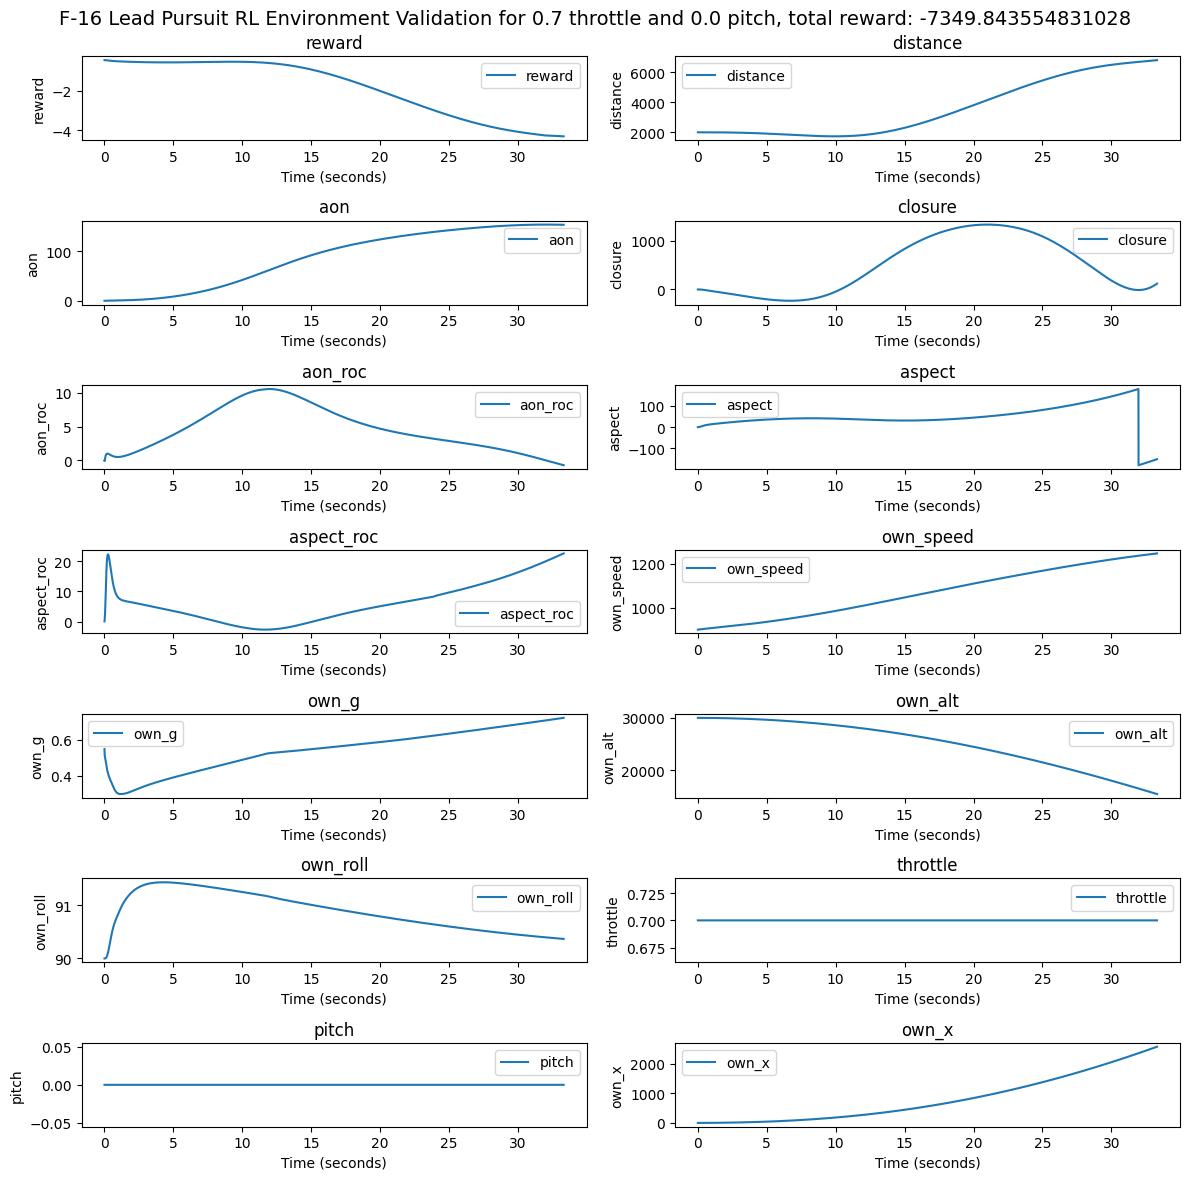

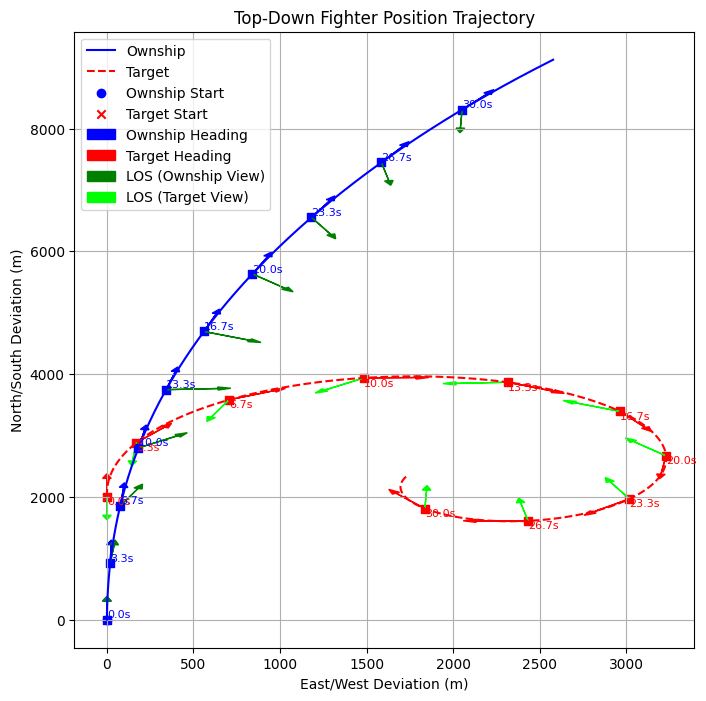

using fixed action for throttle 0.7 and pitch -0.2
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0           0           0
2   Fuel

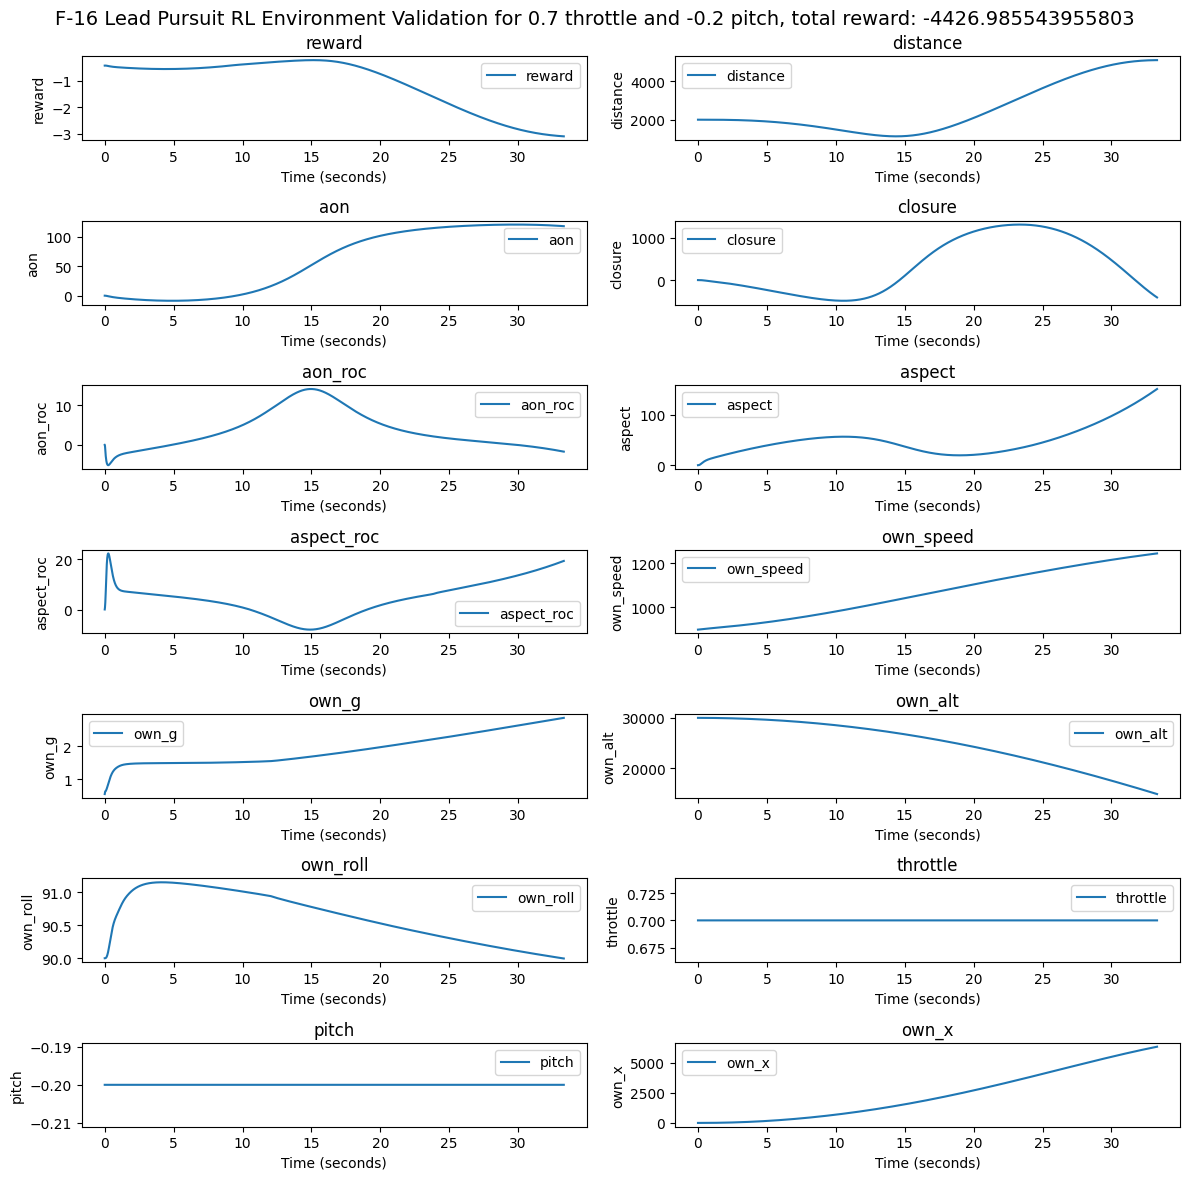

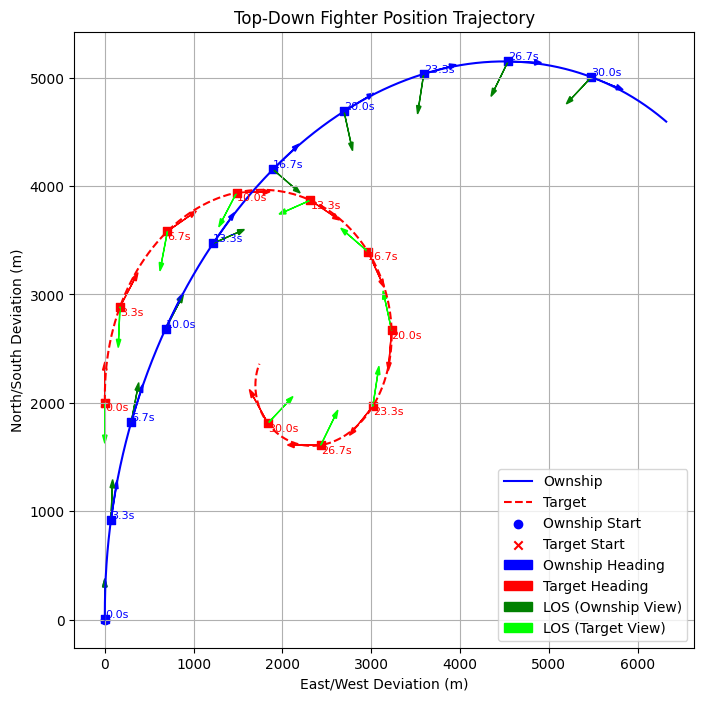

using fixed action for throttle 0.7 and pitch -0.4
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0           0           0
2   Fuel

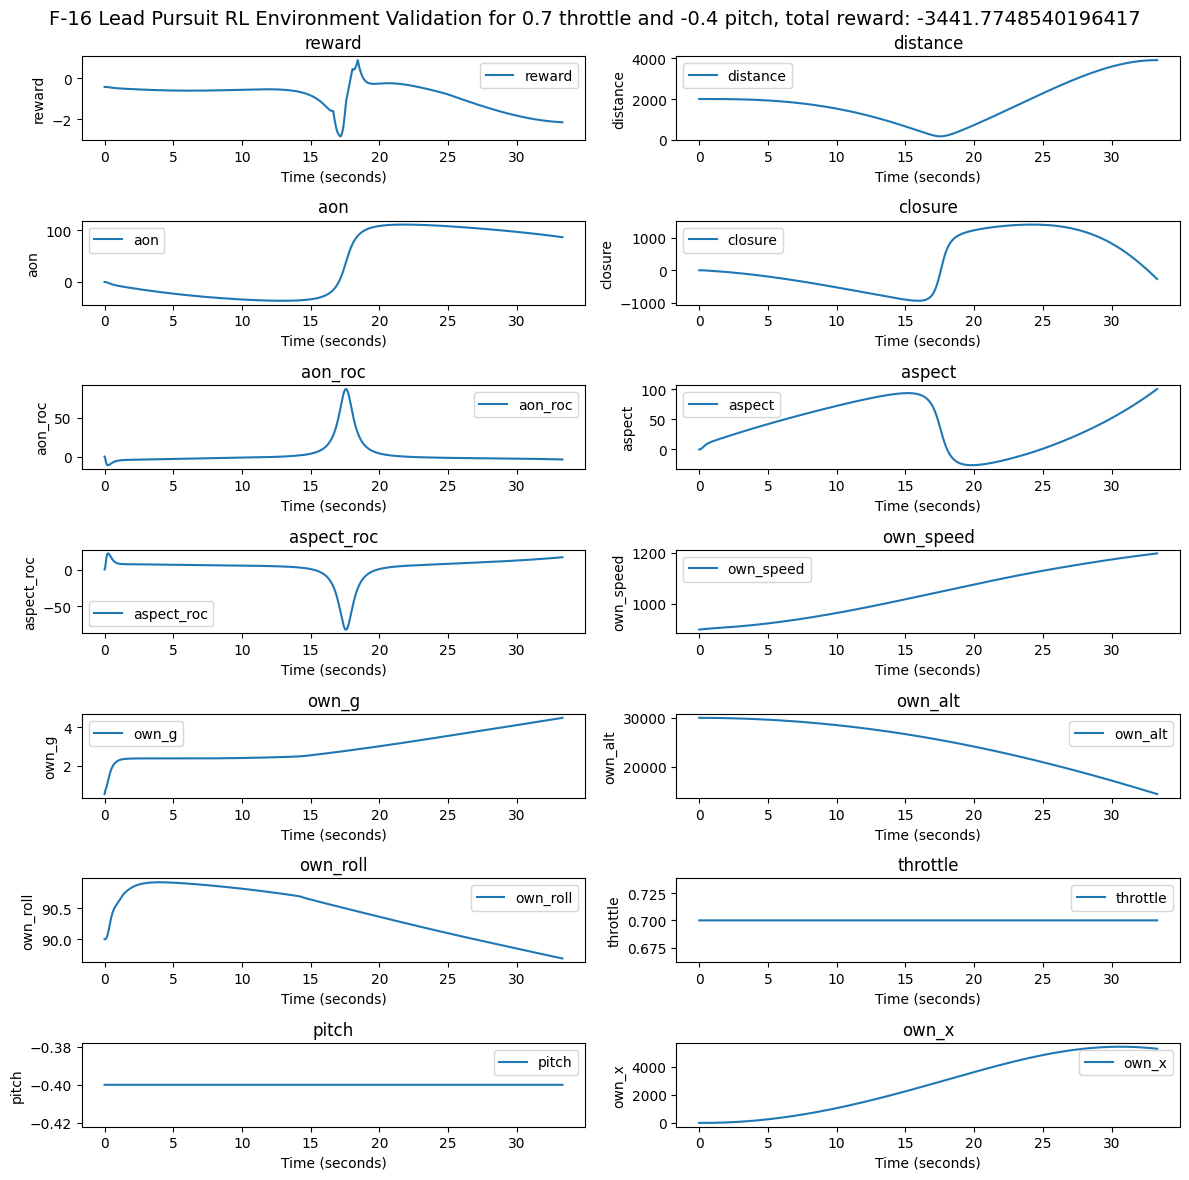

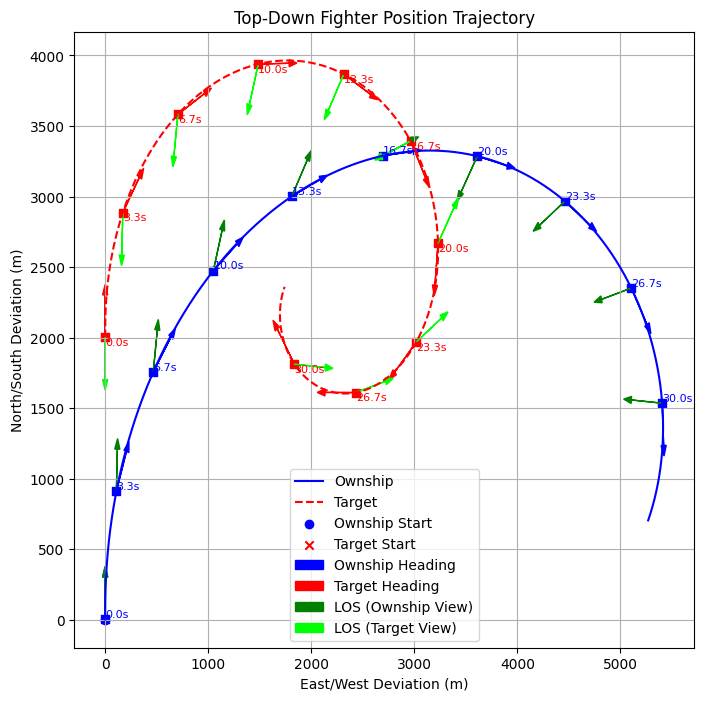

using fixed action for throttle 0.7 and pitch -0.6
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0           0           0
2   Fuel

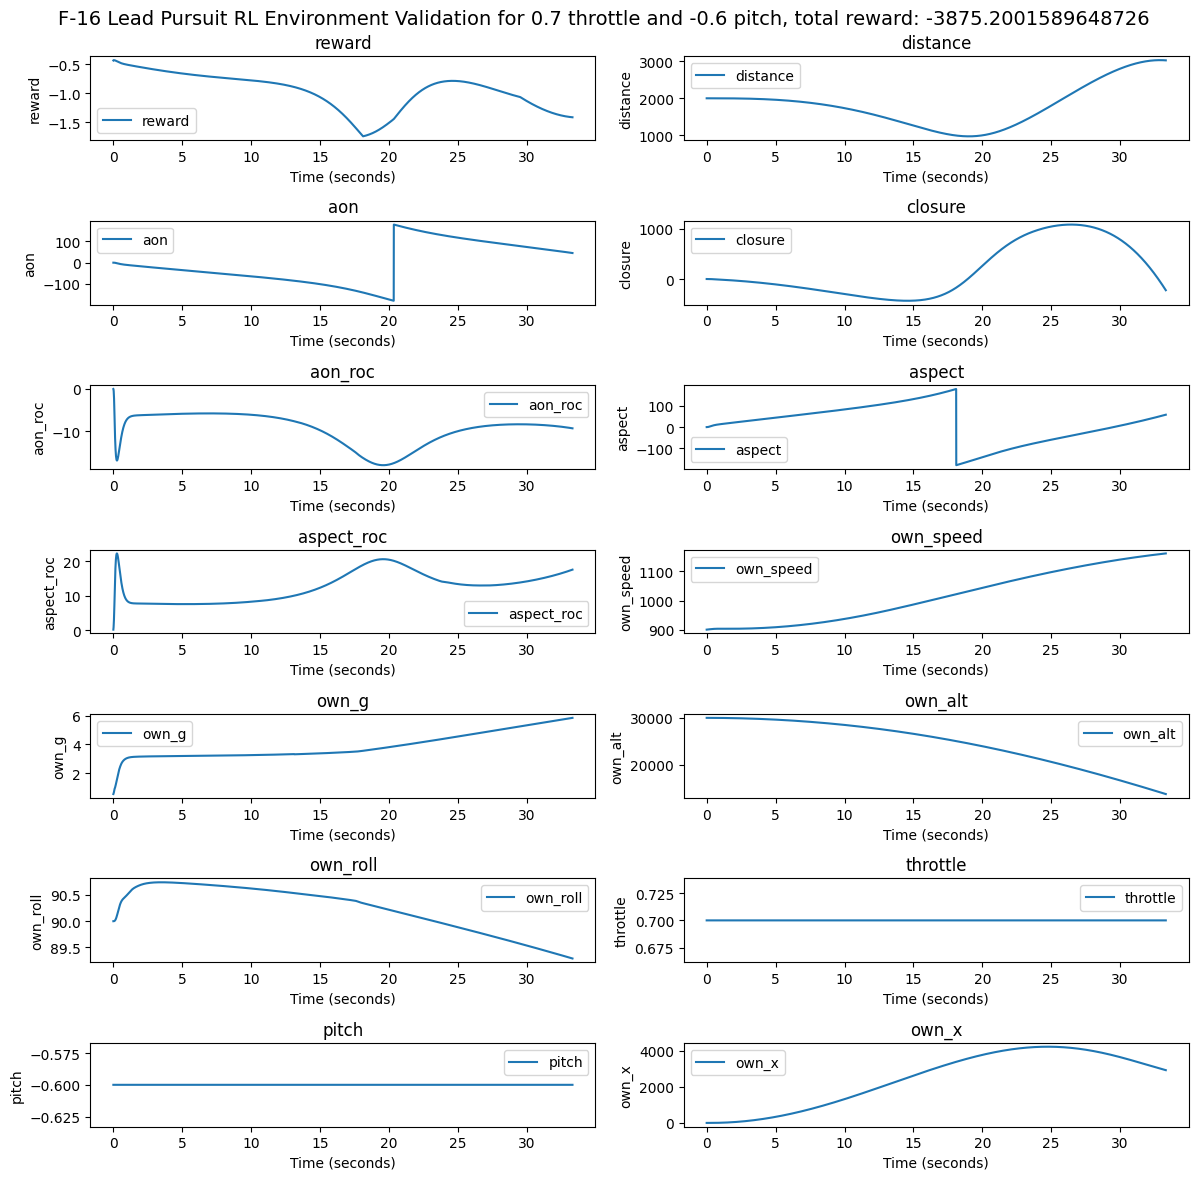

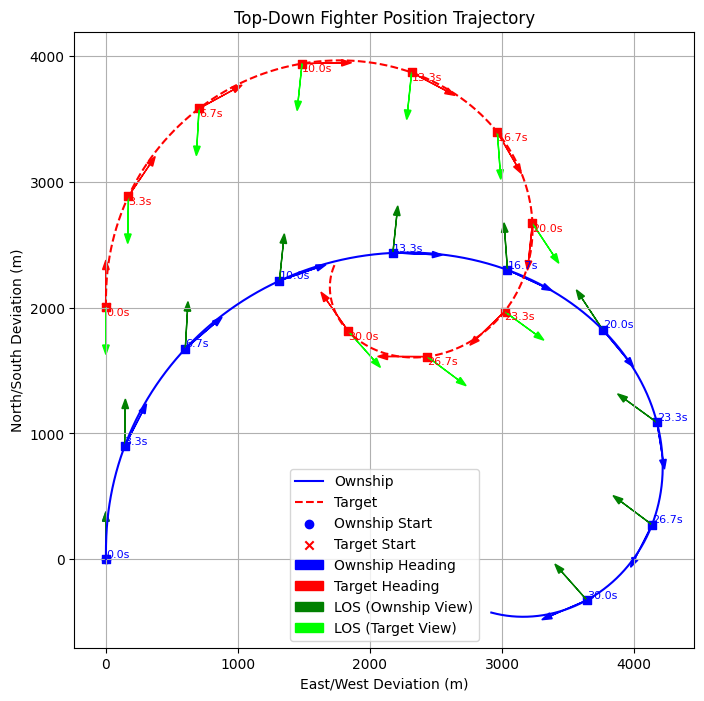

using fixed action for throttle 0.7 and pitch -0.8
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0           0           0
2   Fuel

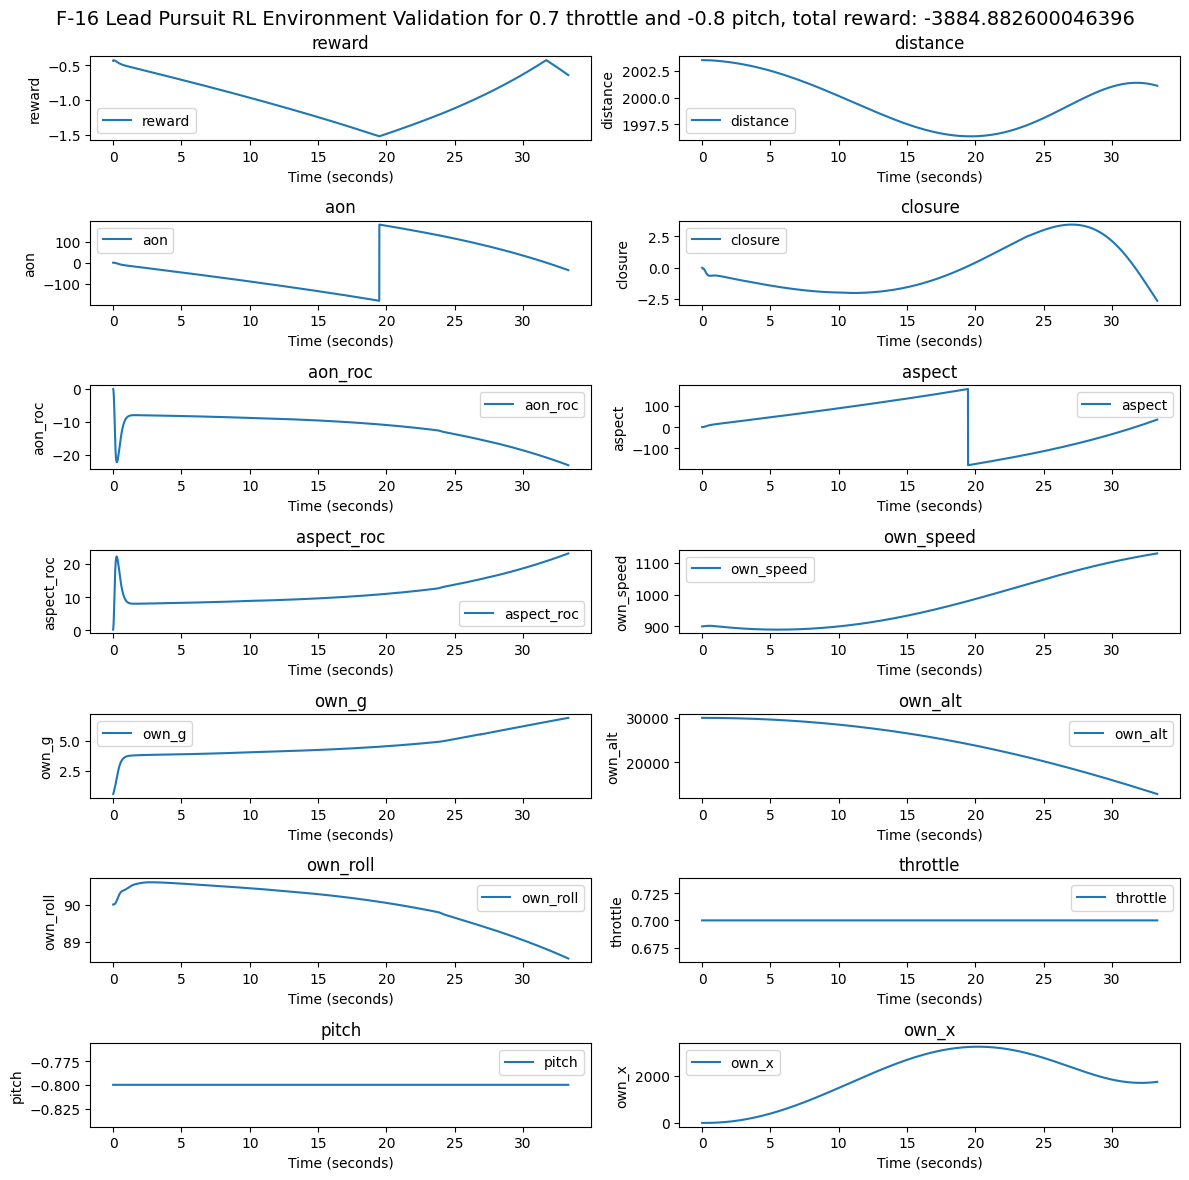

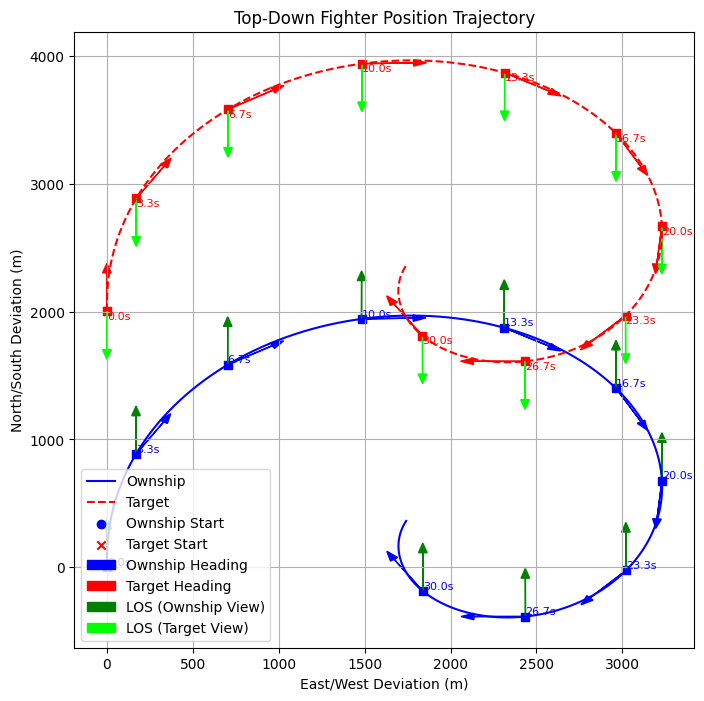

using fixed action for throttle 0.7 and pitch -1.0
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0           0           0
2   Fuel

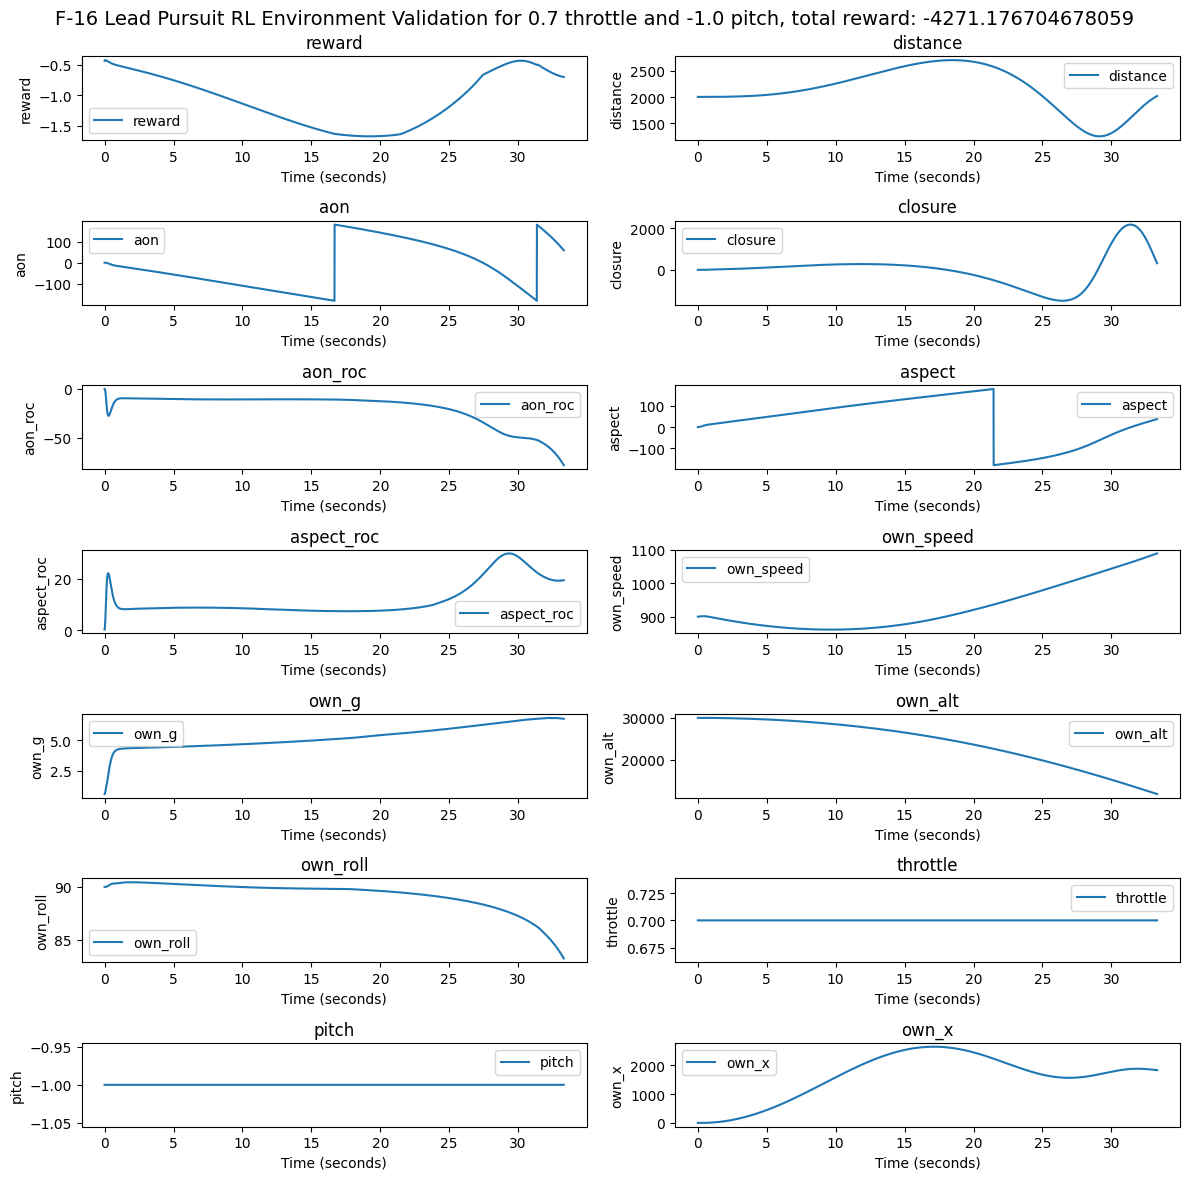

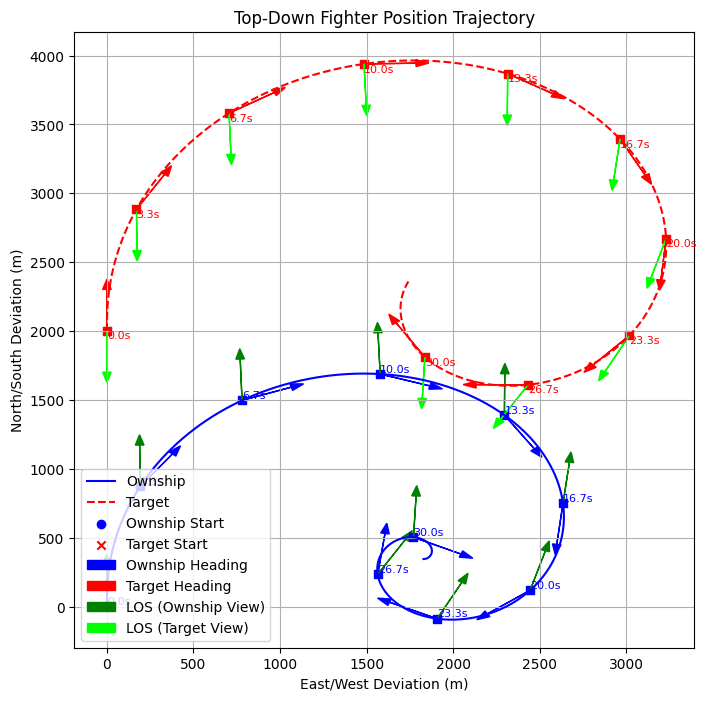

In [34]:
for pitch in [0.0, -0.2, -0.4, -0.6, -0.8, -1.0]:
    testEnvironment(fixed_action=np.array([0.7, pitch]), time_in_seconds=True)

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_50000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0      

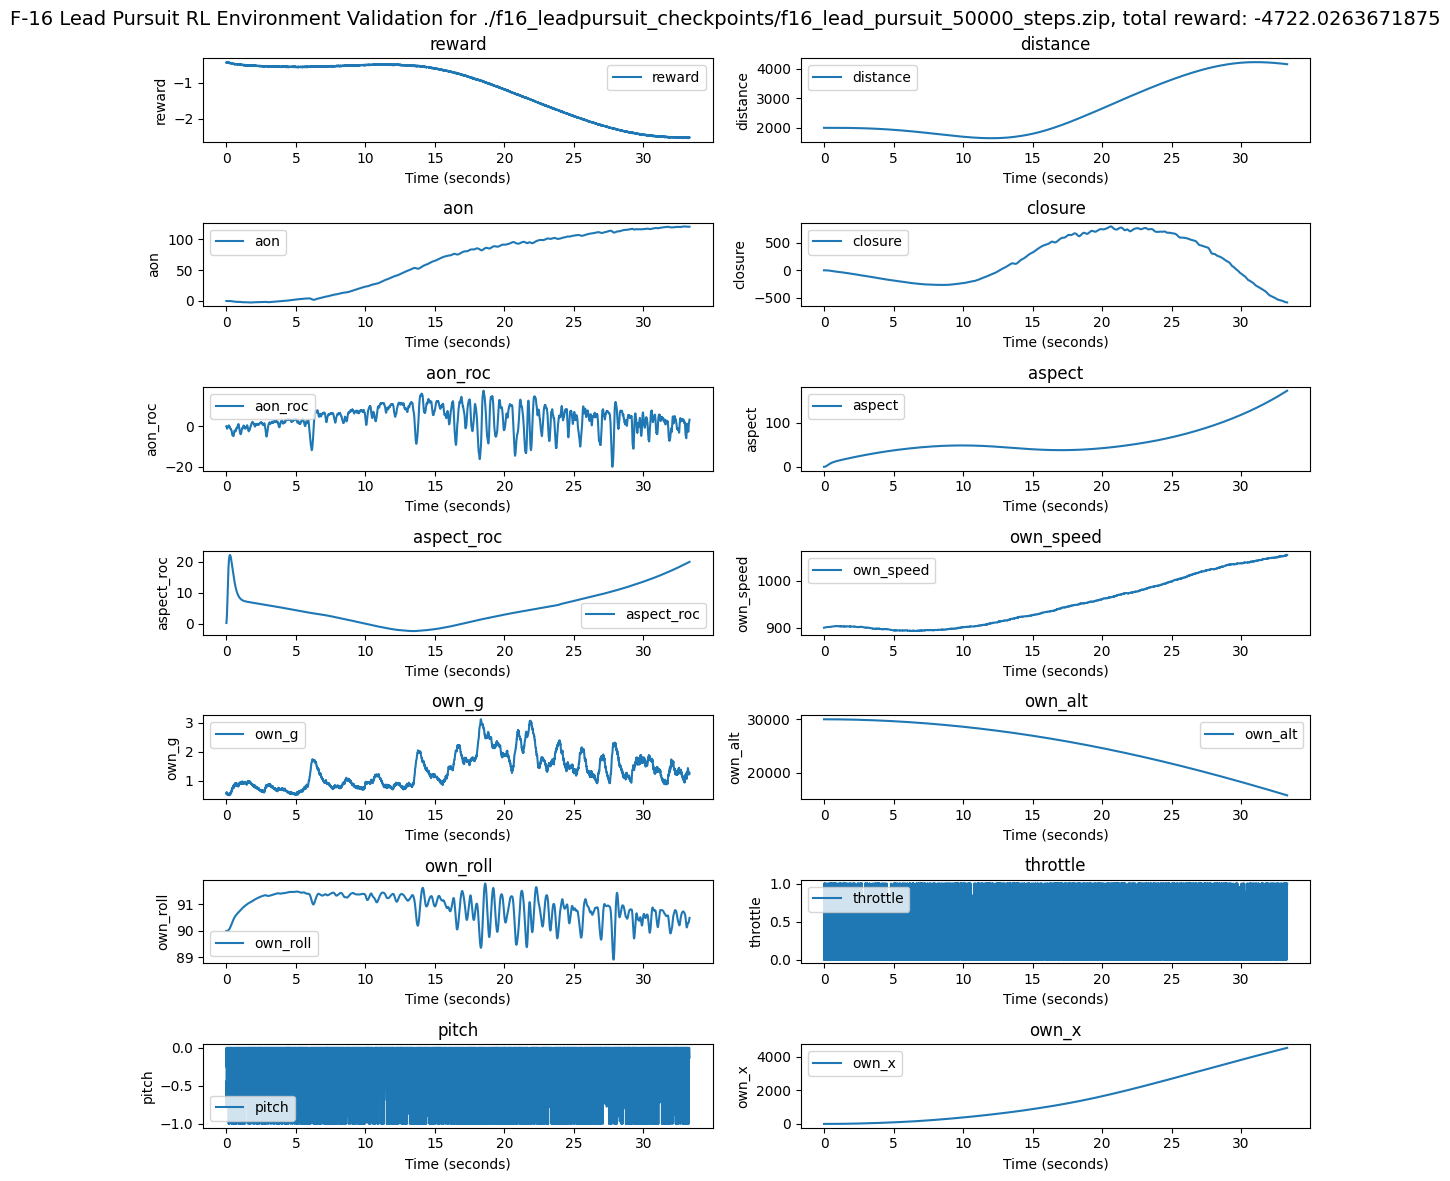

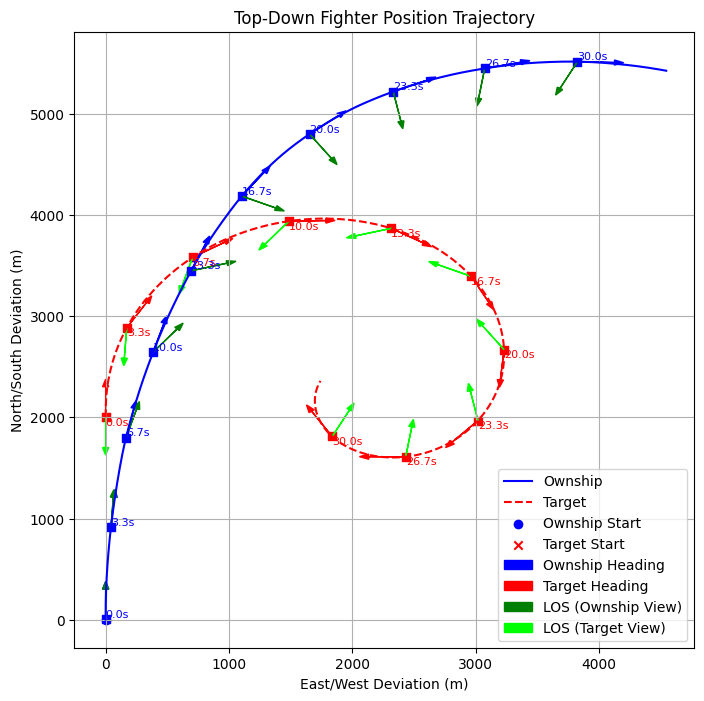

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_100000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0     

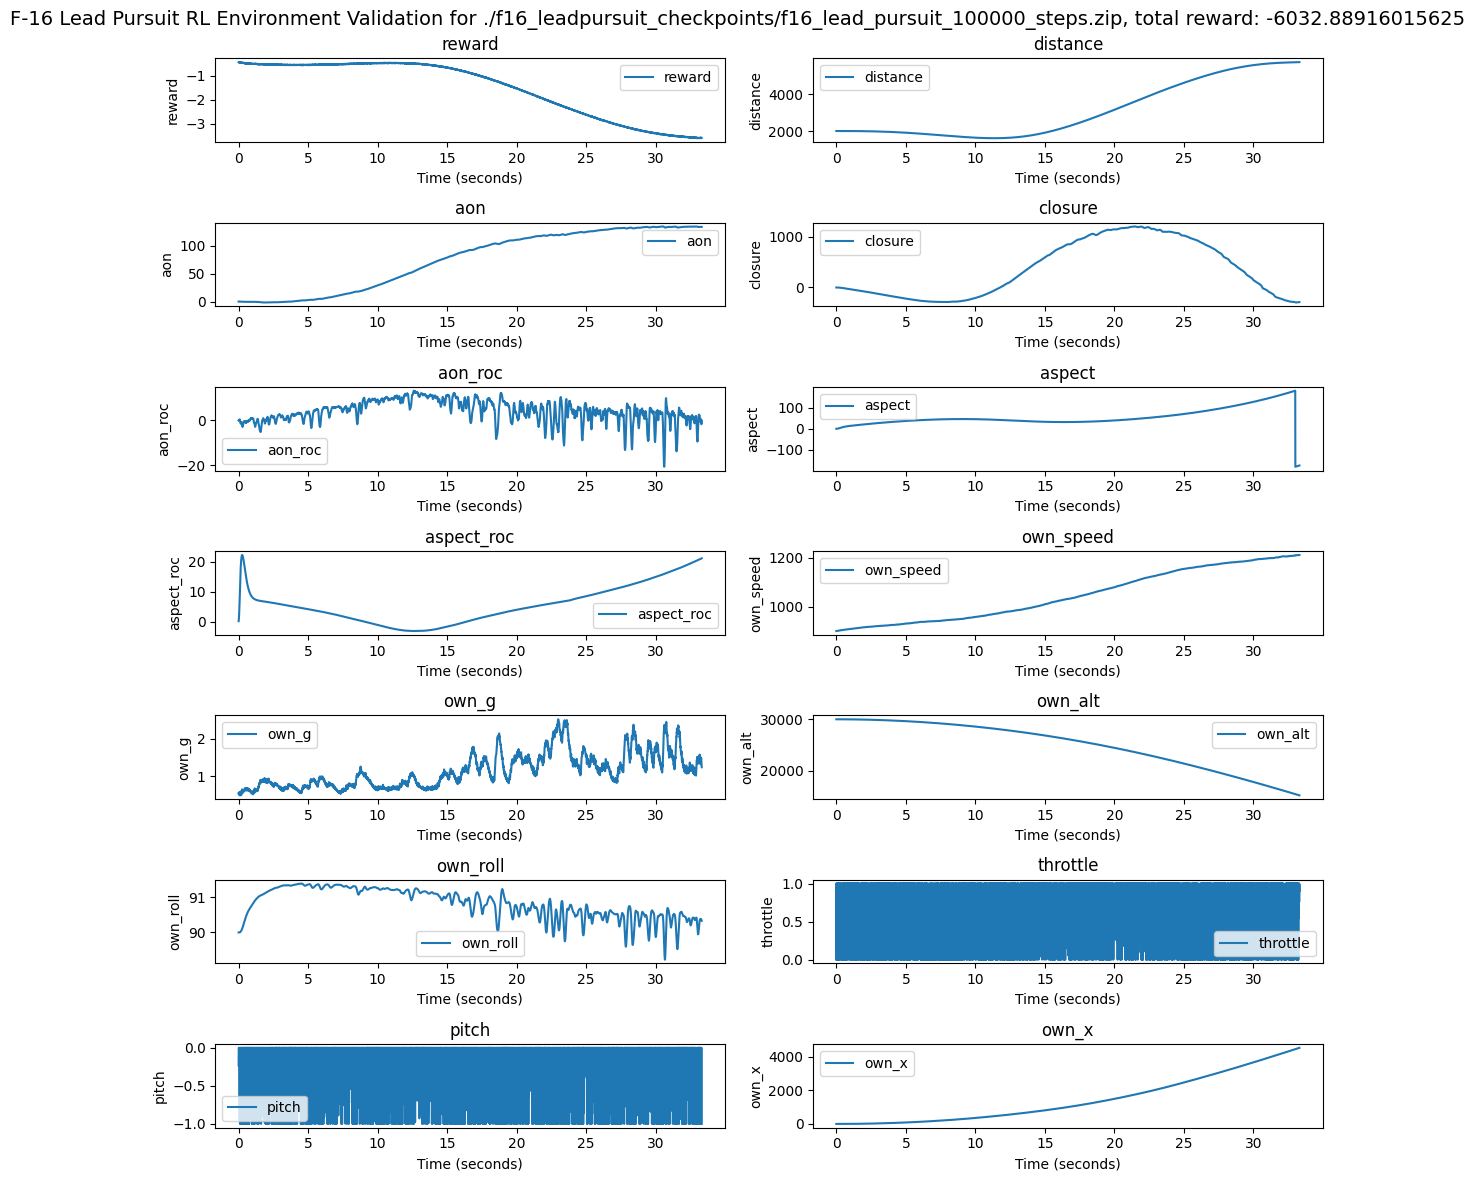

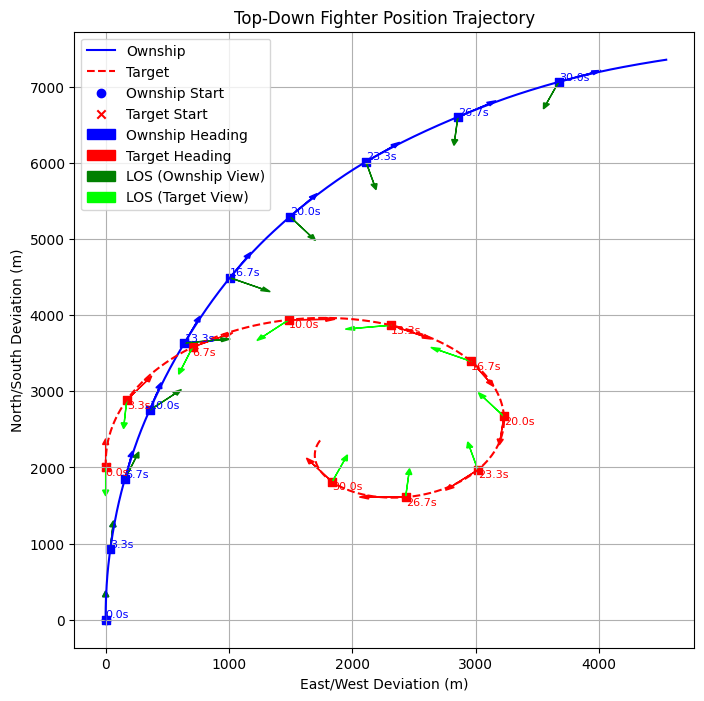

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_150000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0     

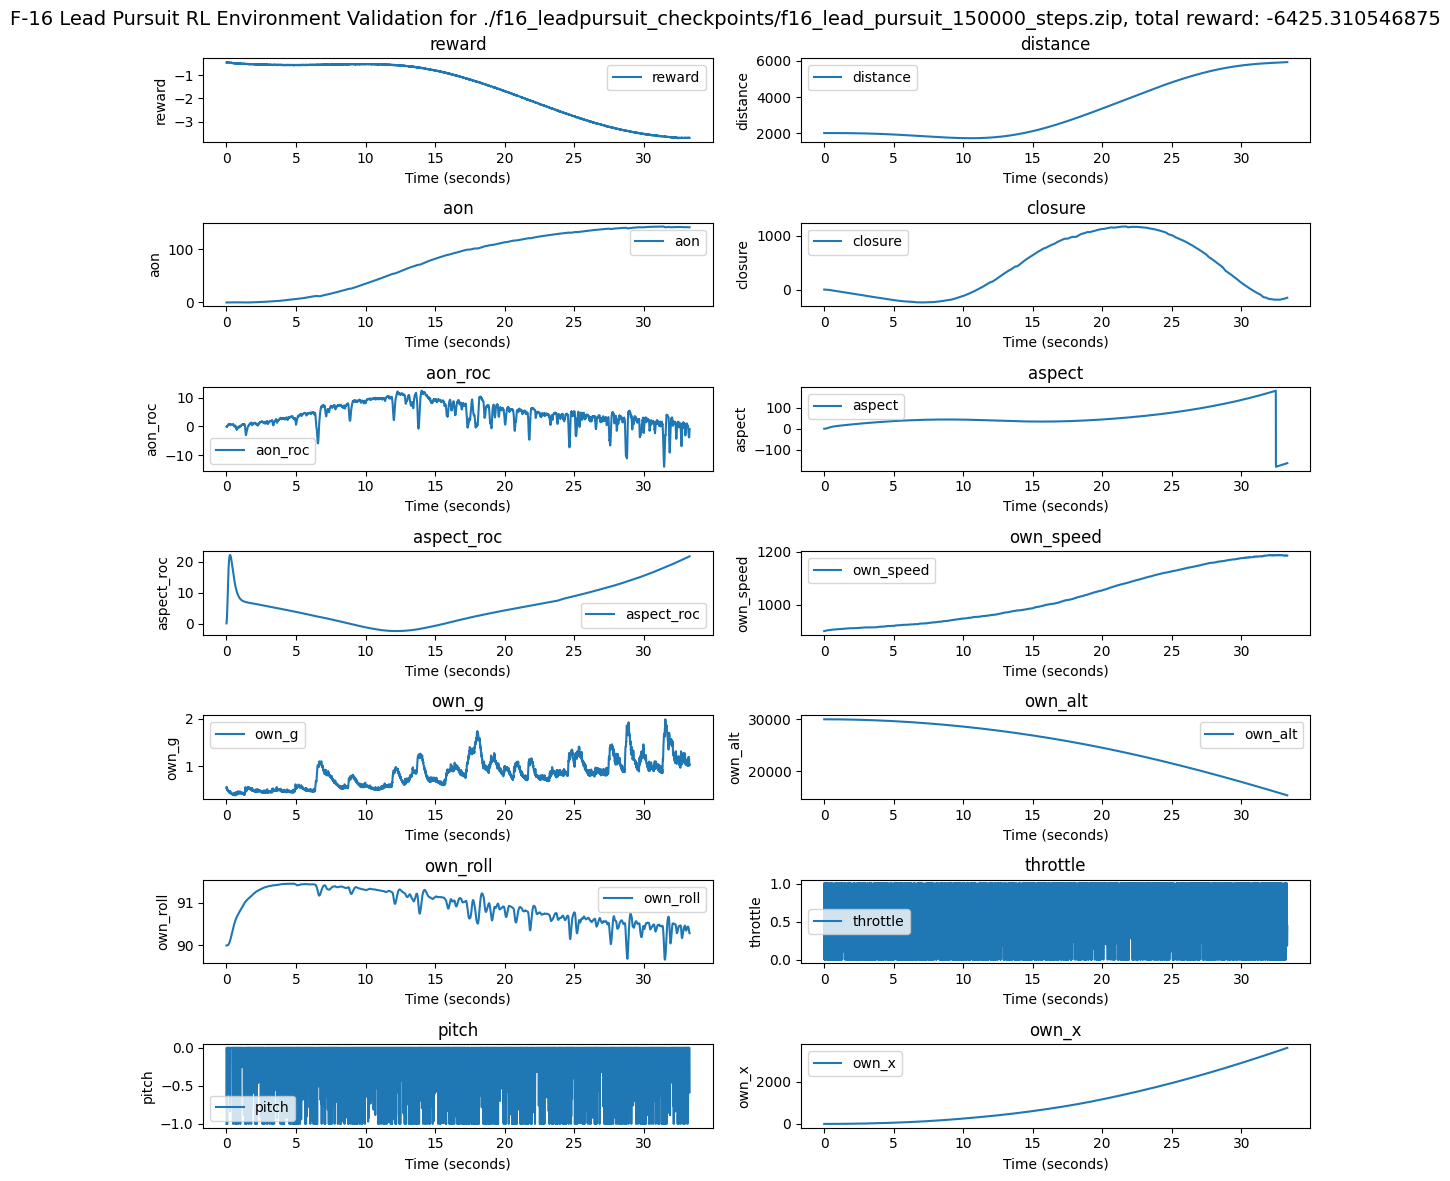

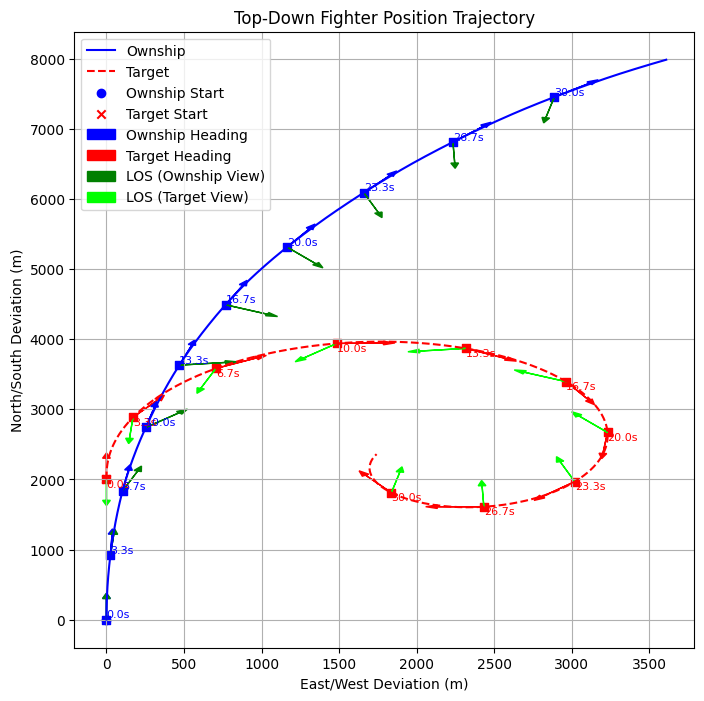

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_200000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0     

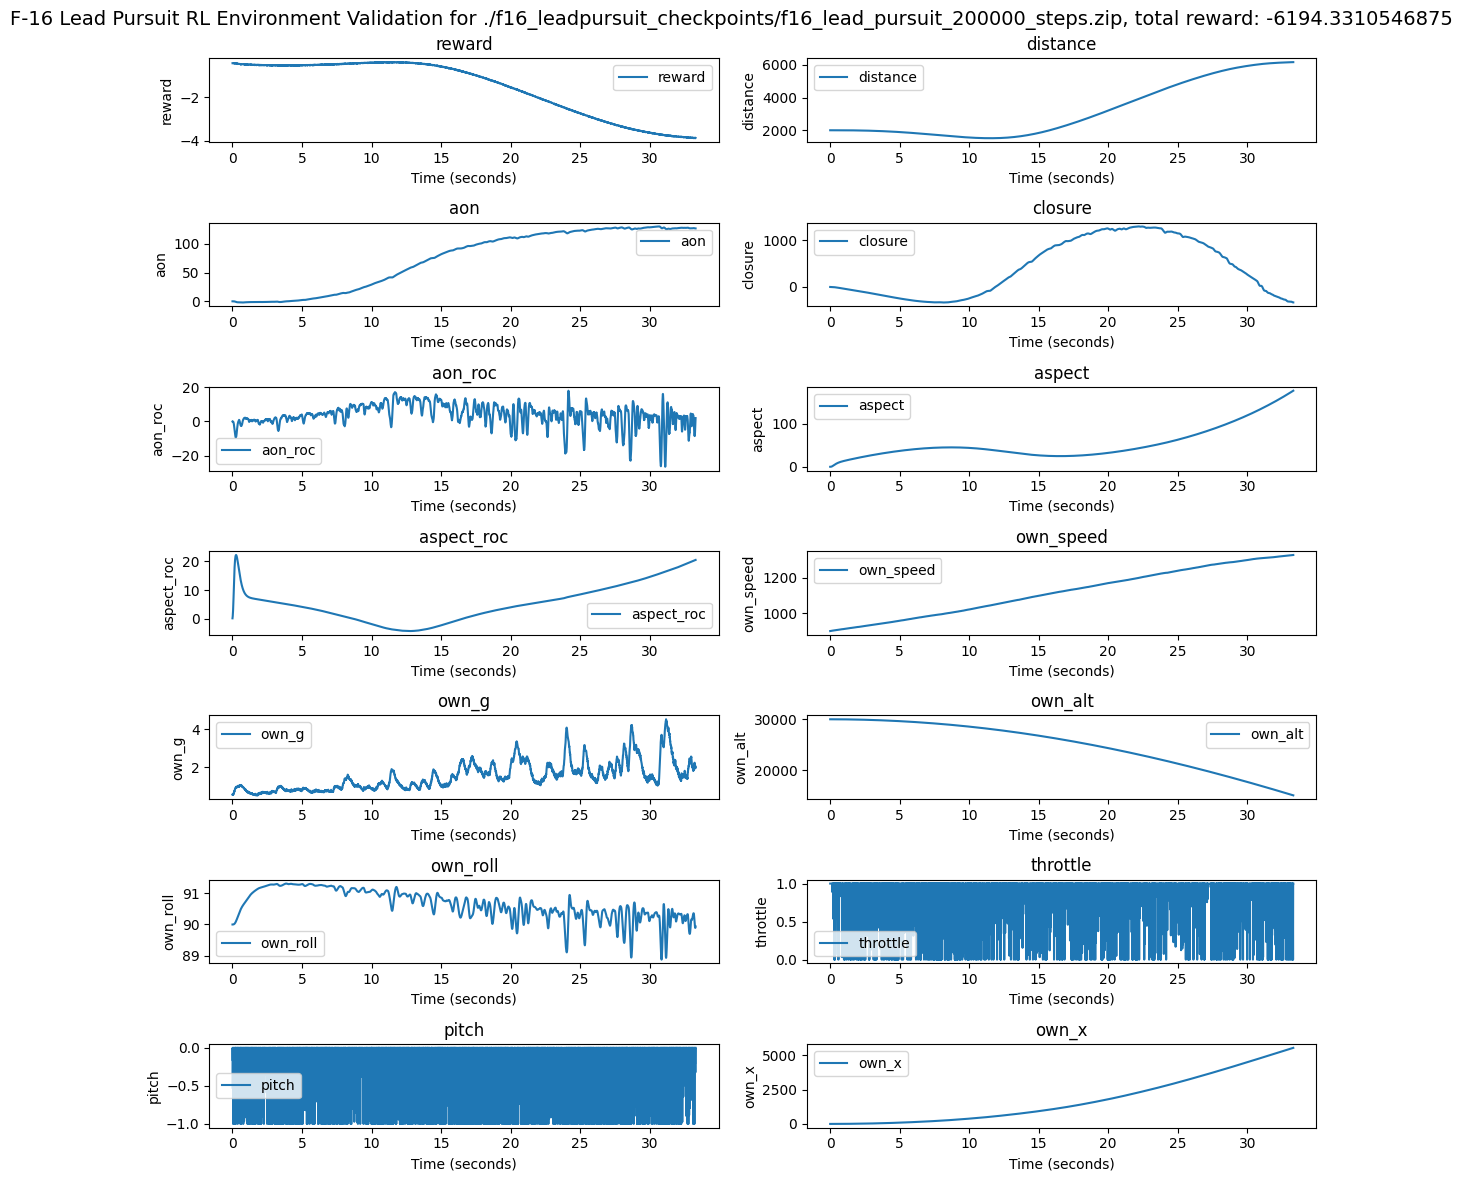

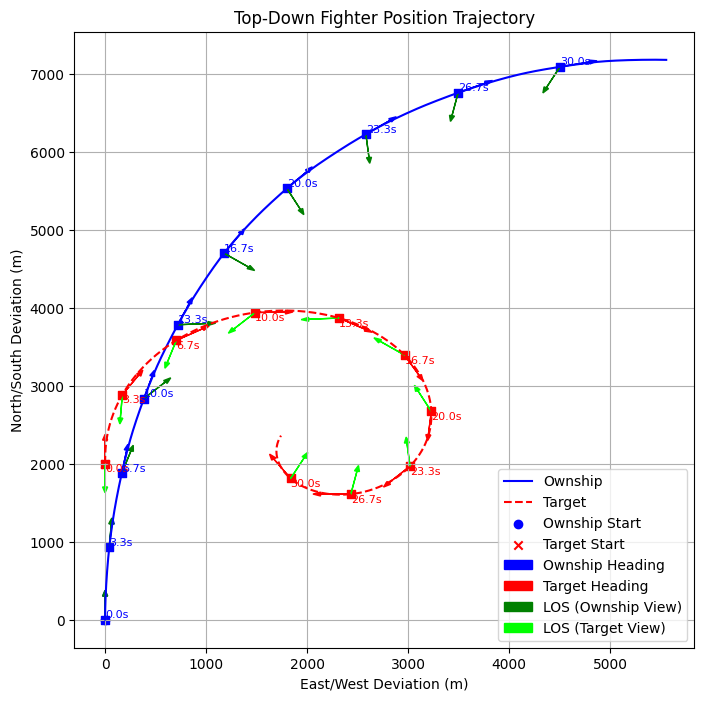

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_250000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5           0     

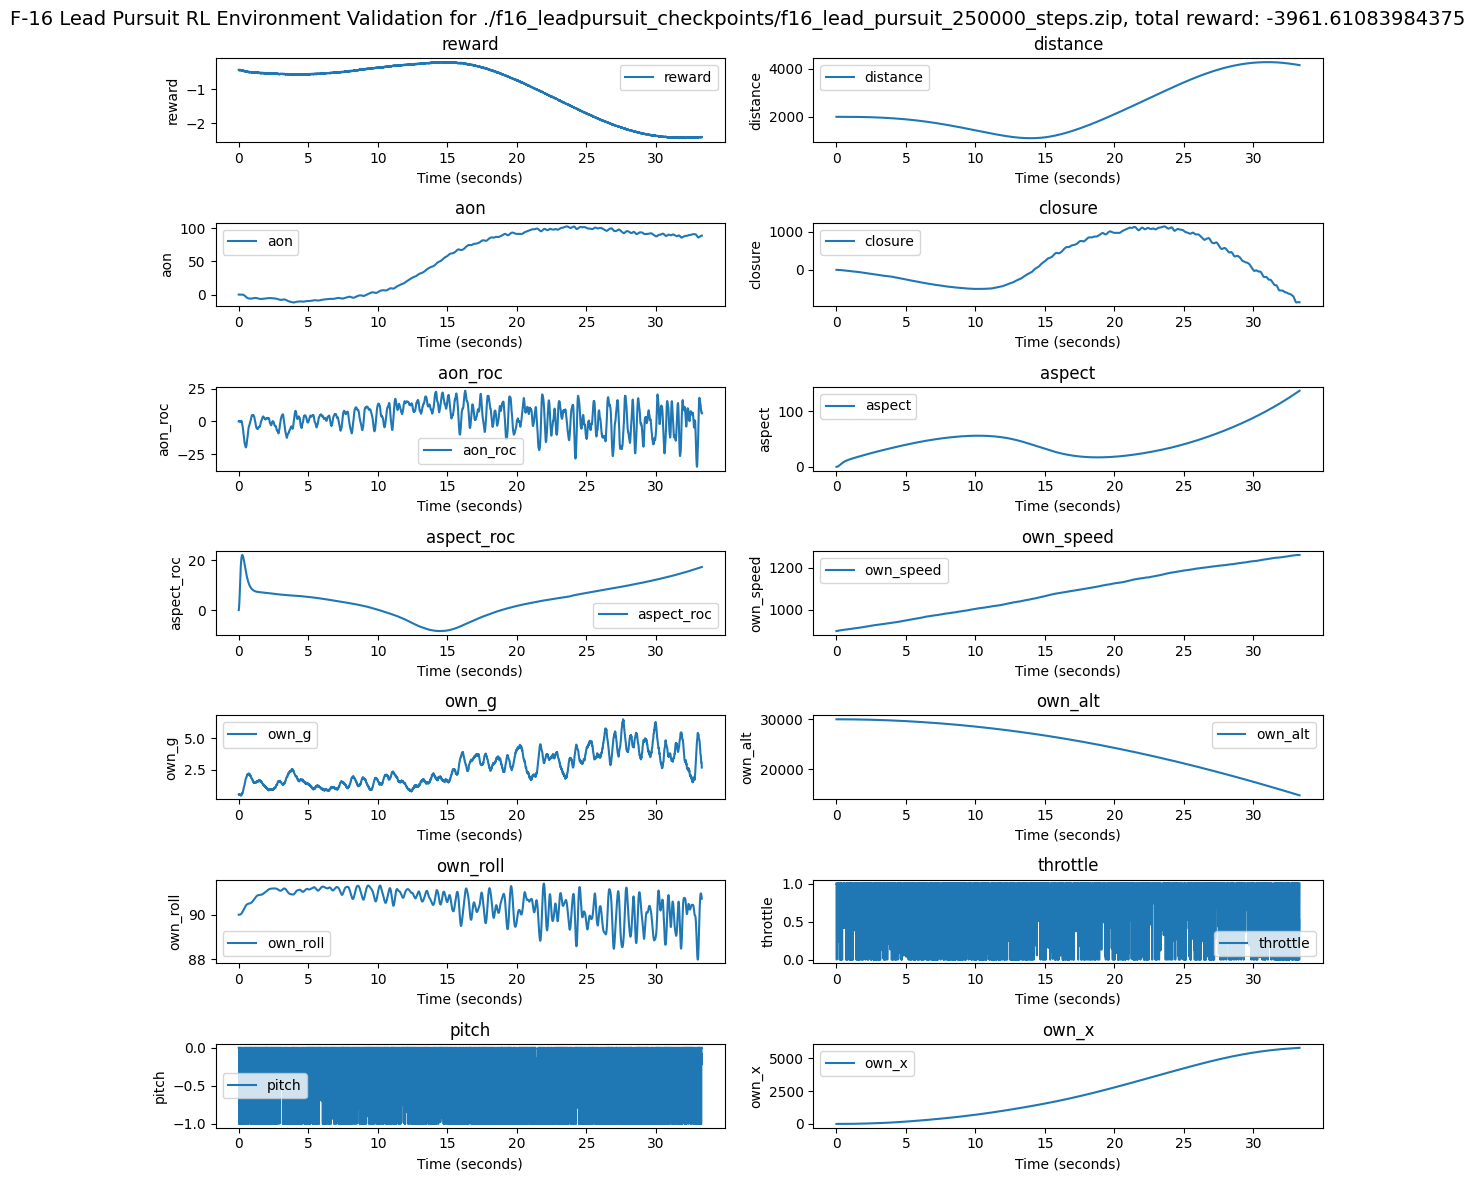

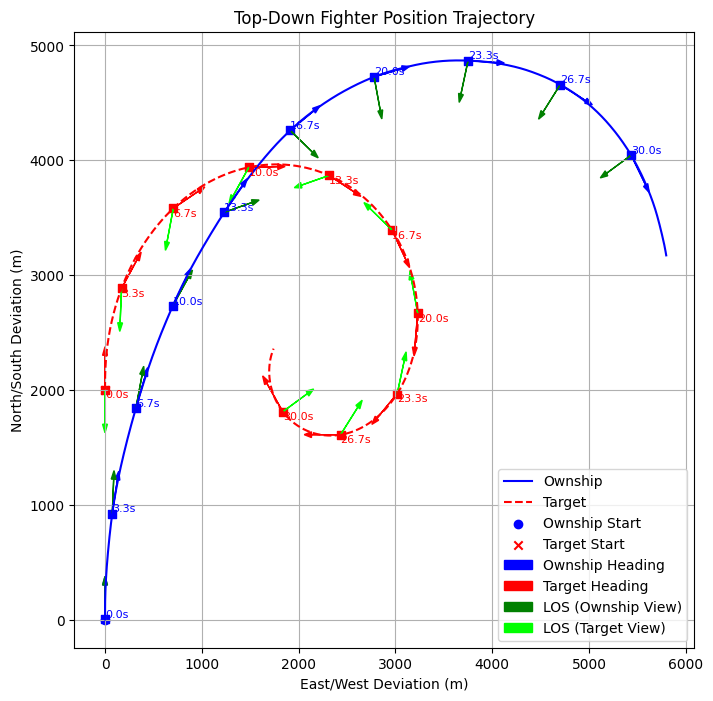

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_250k_no_fcs_250k_with_fcs_50000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65

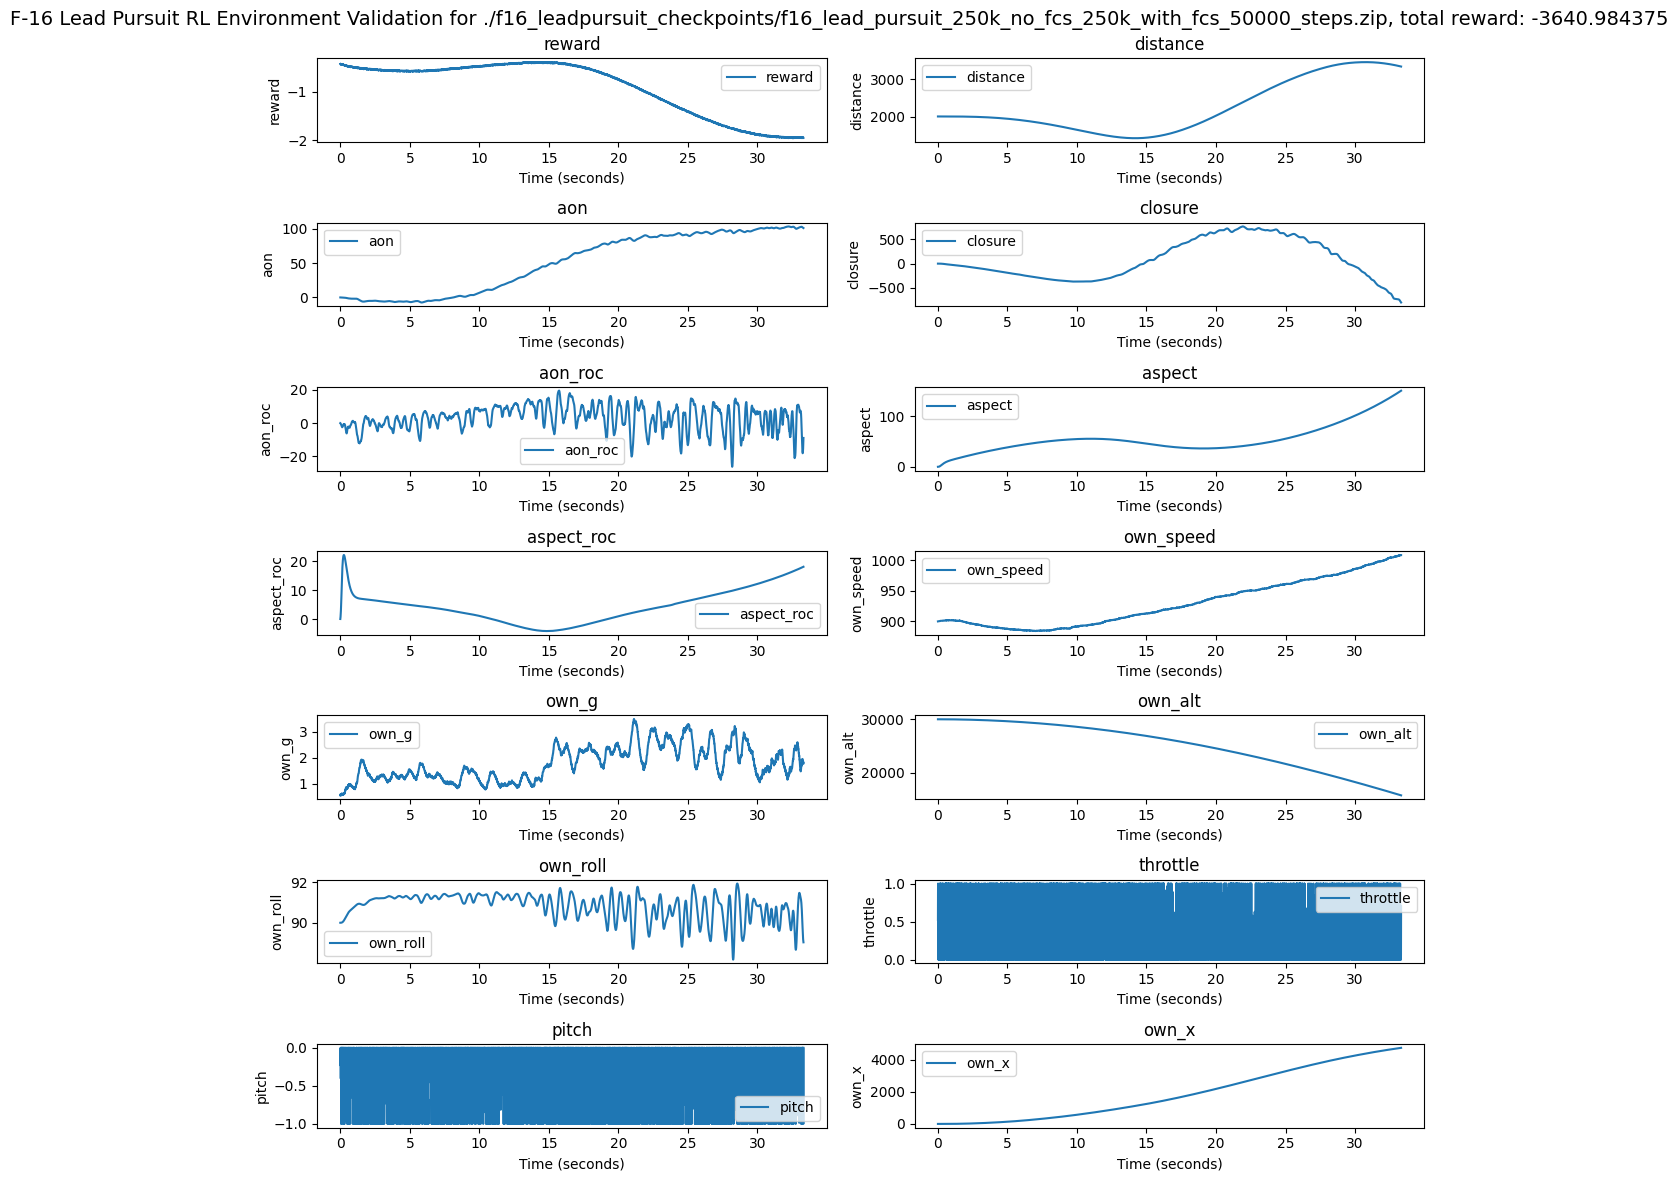

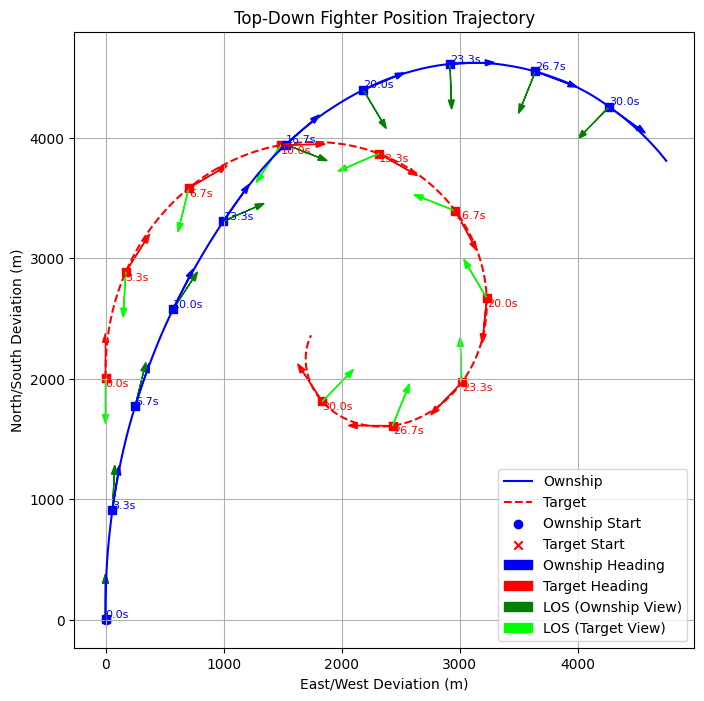

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_250k_no_fcs_250k_with_fcs_100000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -6

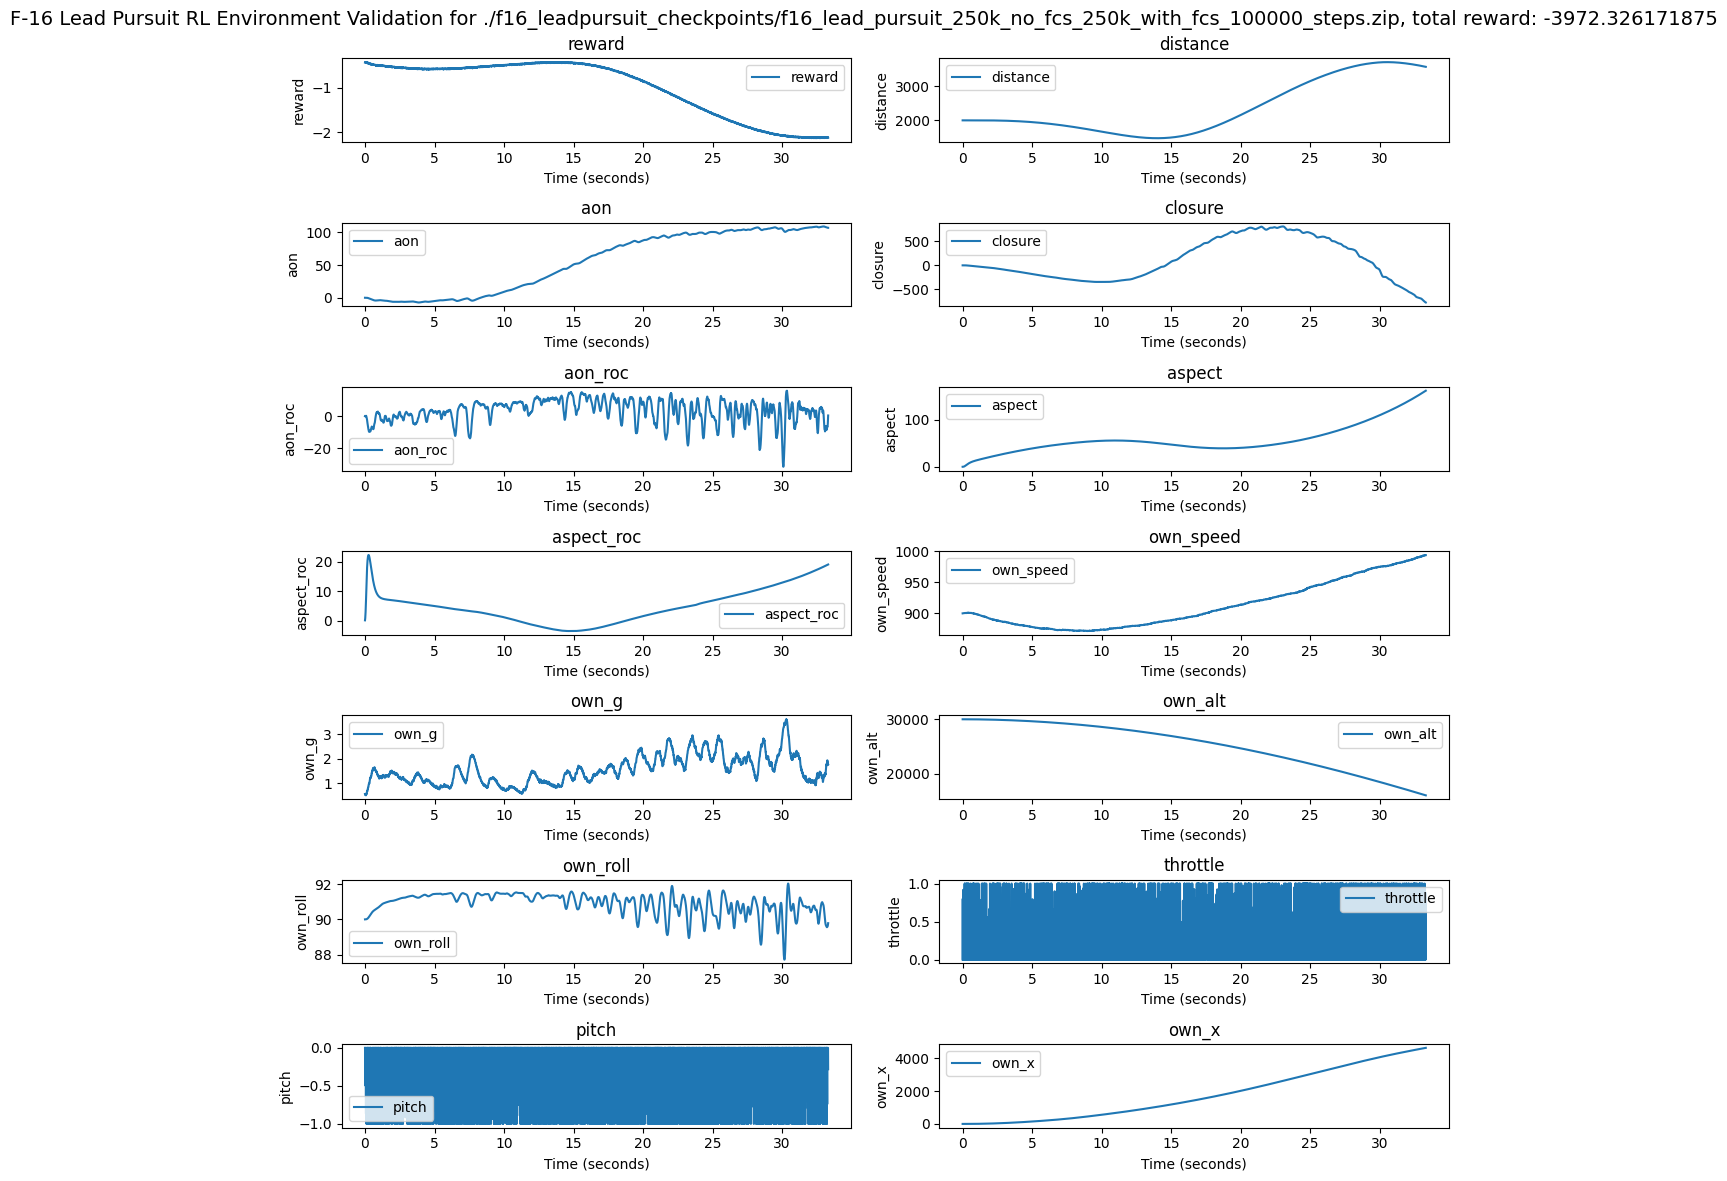

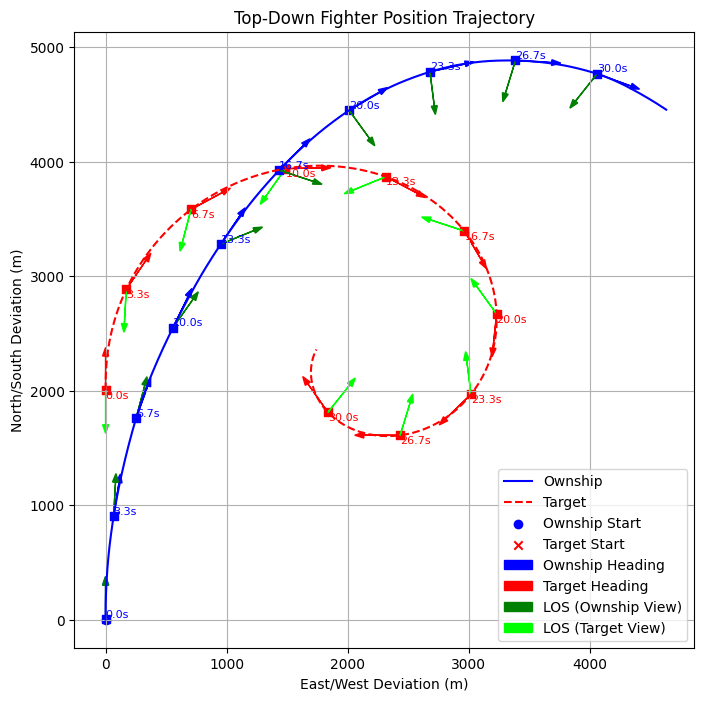

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_250k_no_fcs_250k_with_fcs_150000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -6

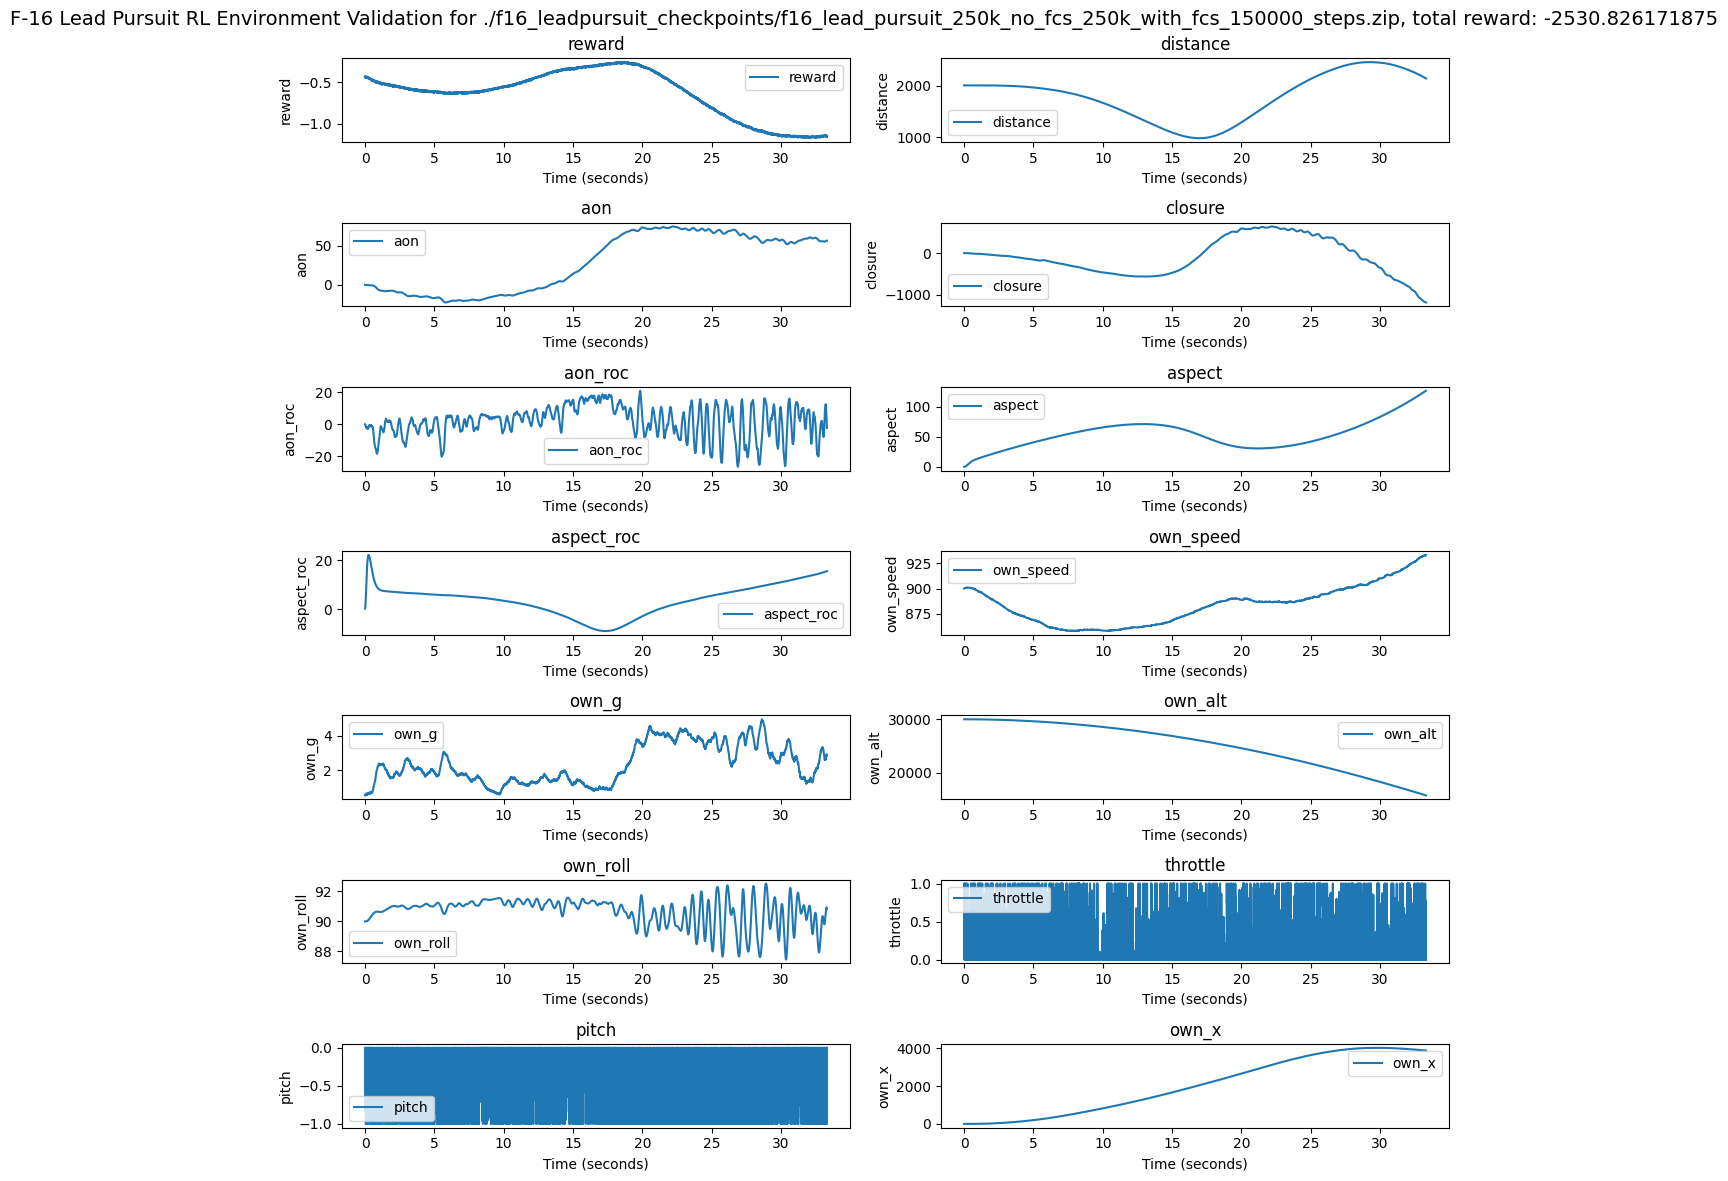

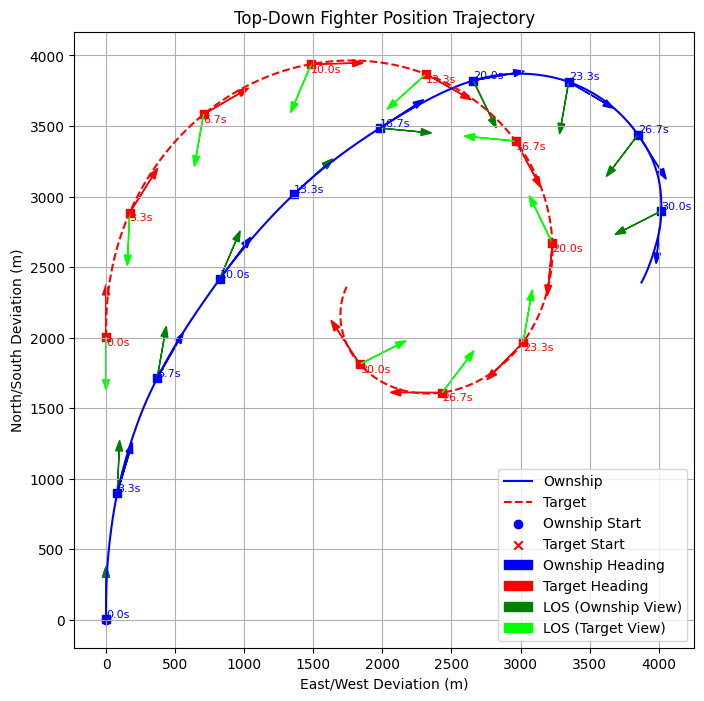

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_250k_no_fcs_250k_with_fcs_200000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -6

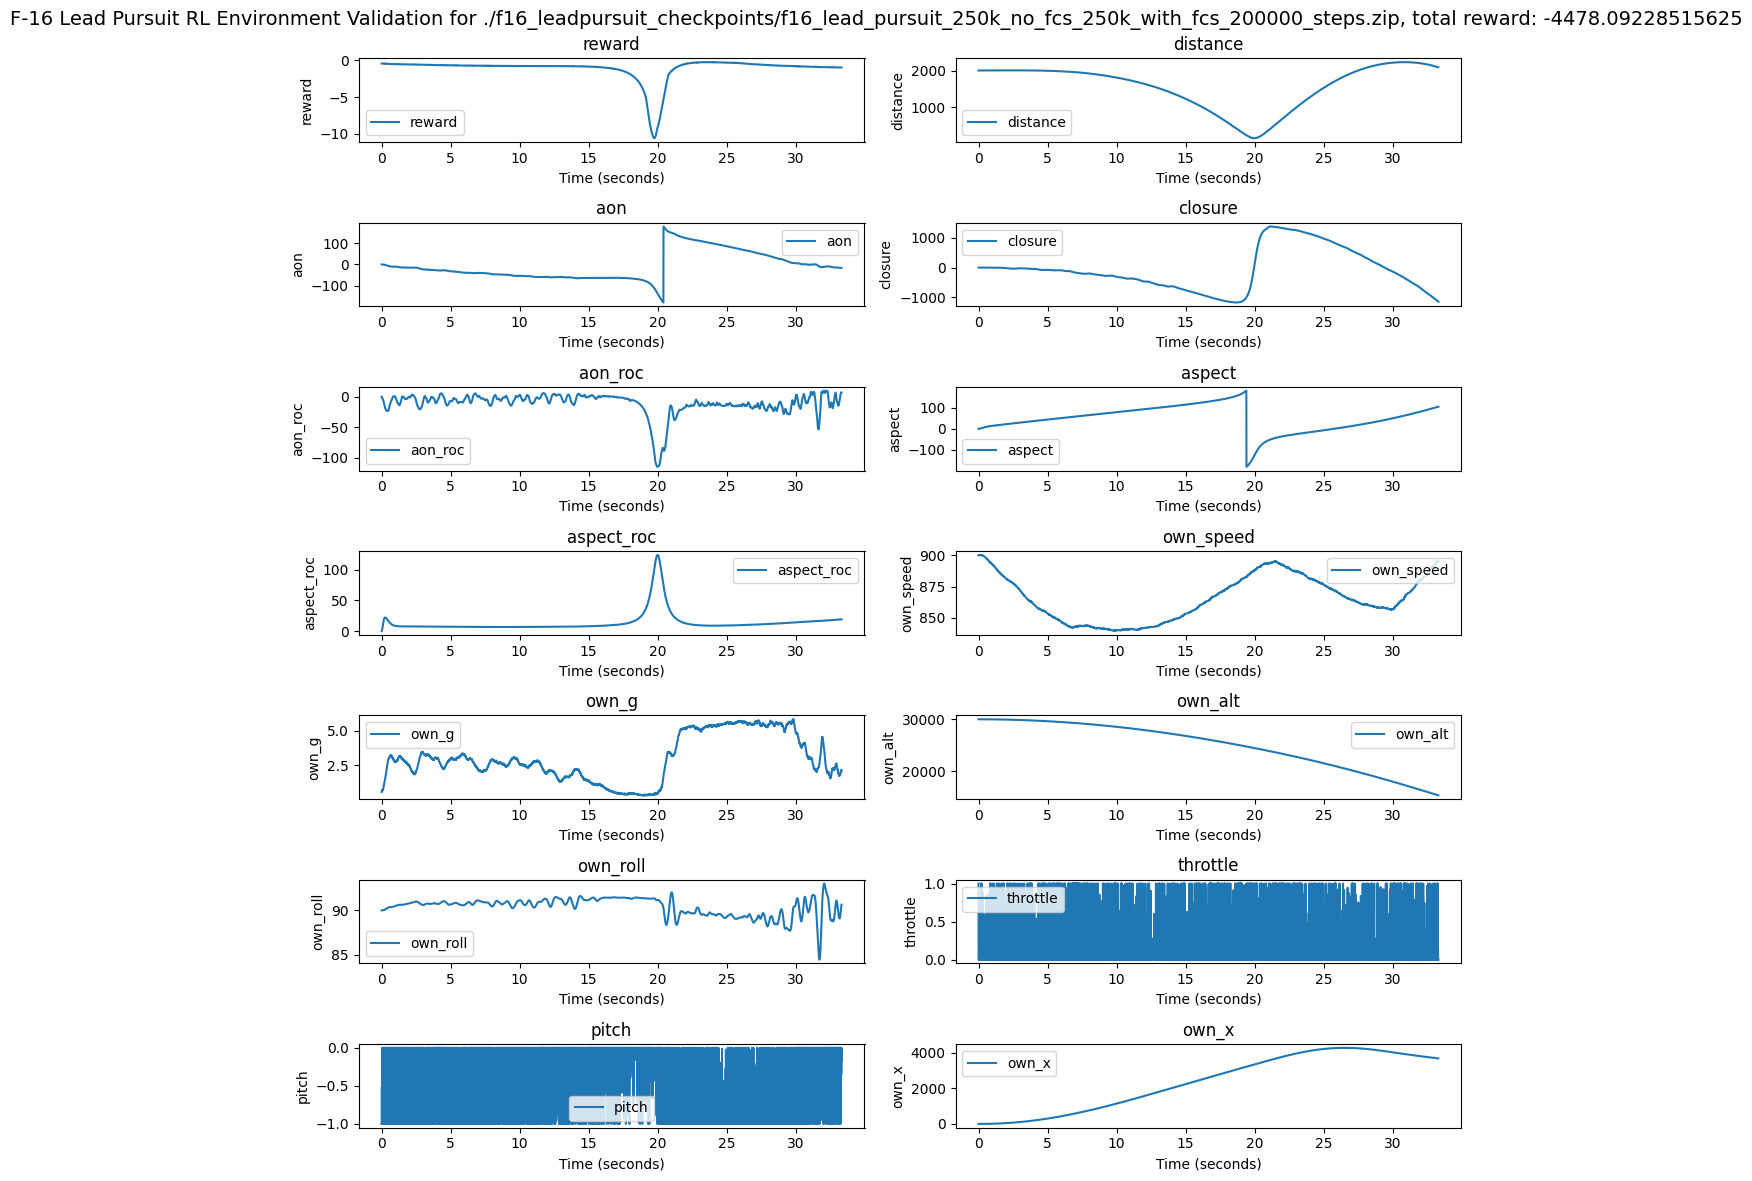

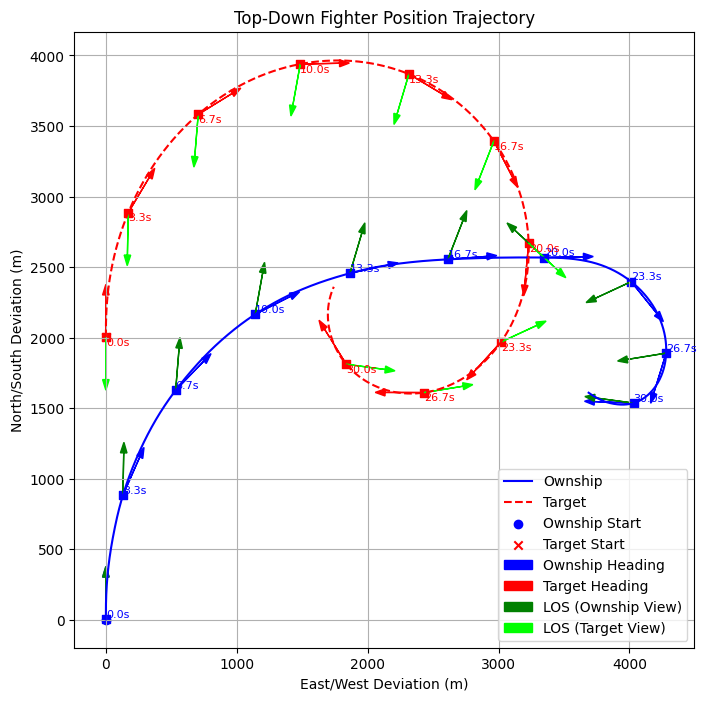

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_250k_no_fcs_250k_with_fcs_250000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -6

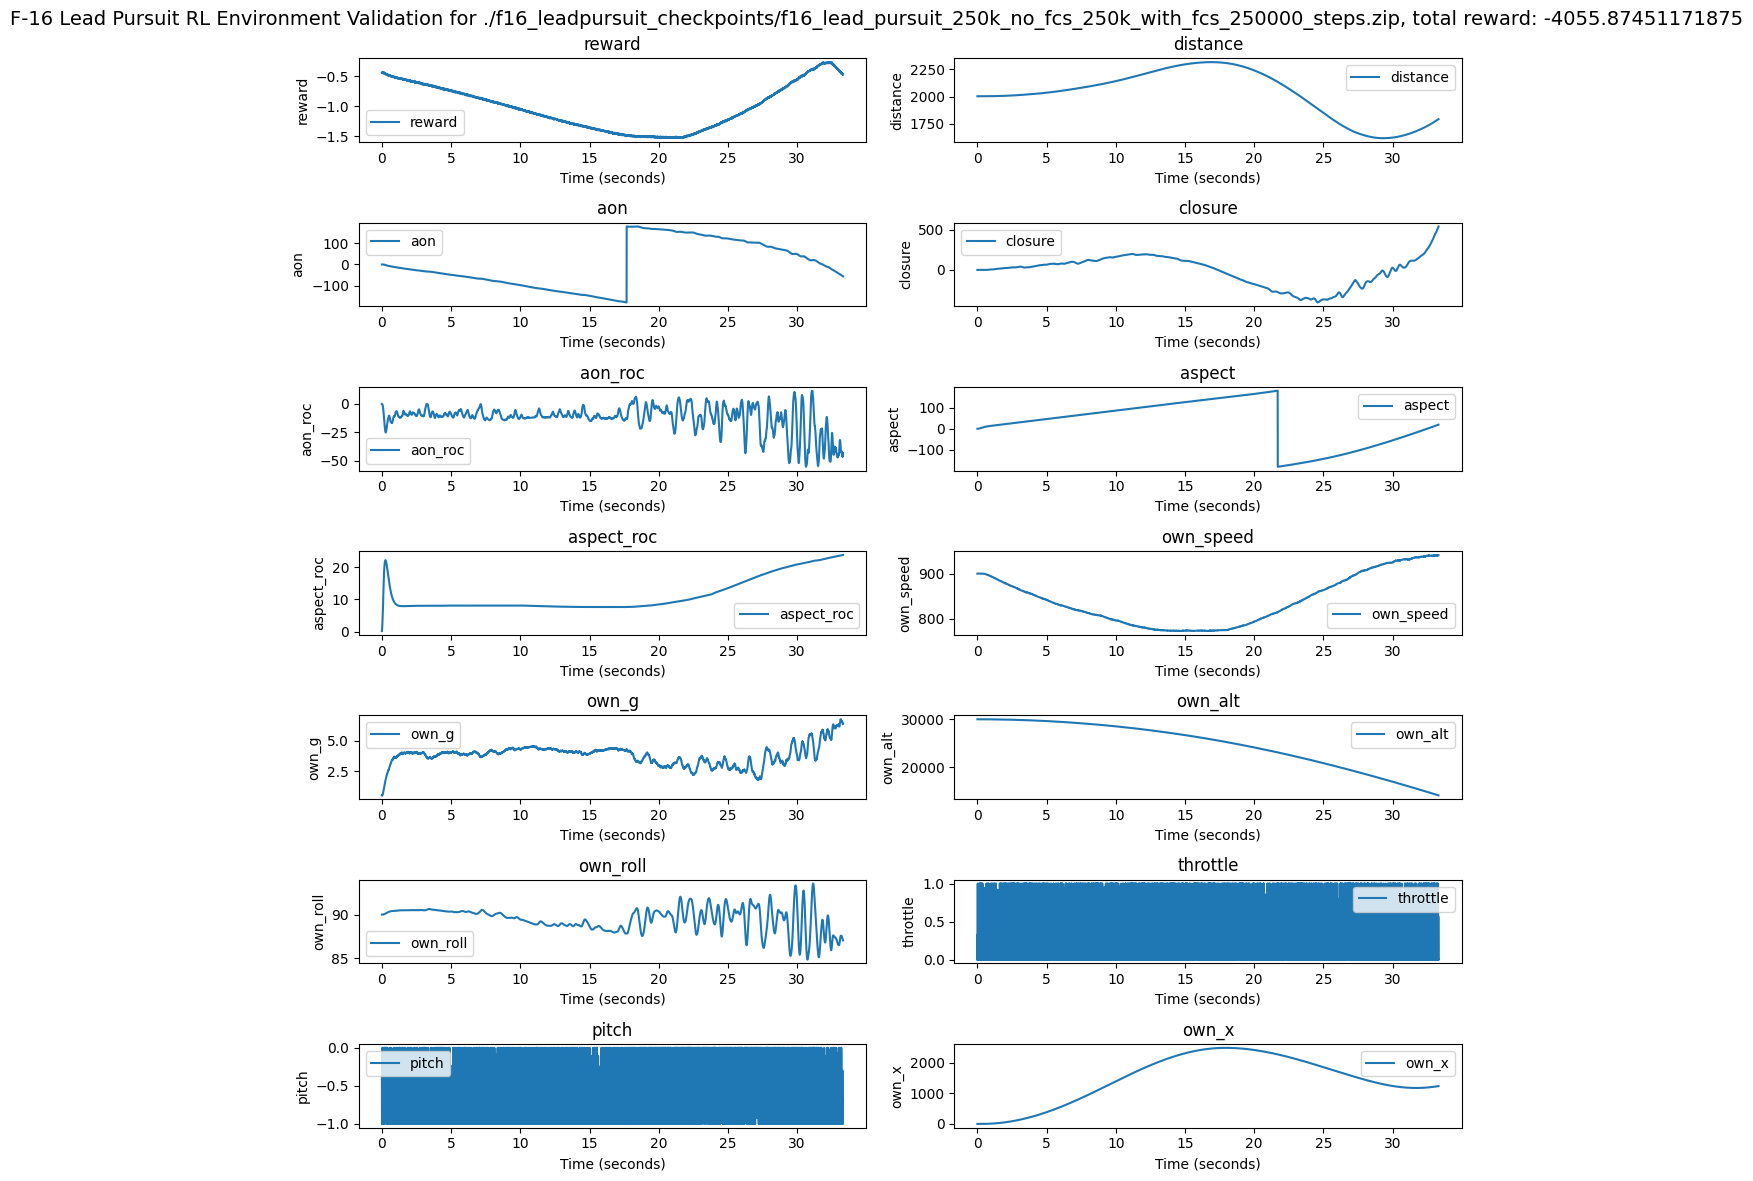

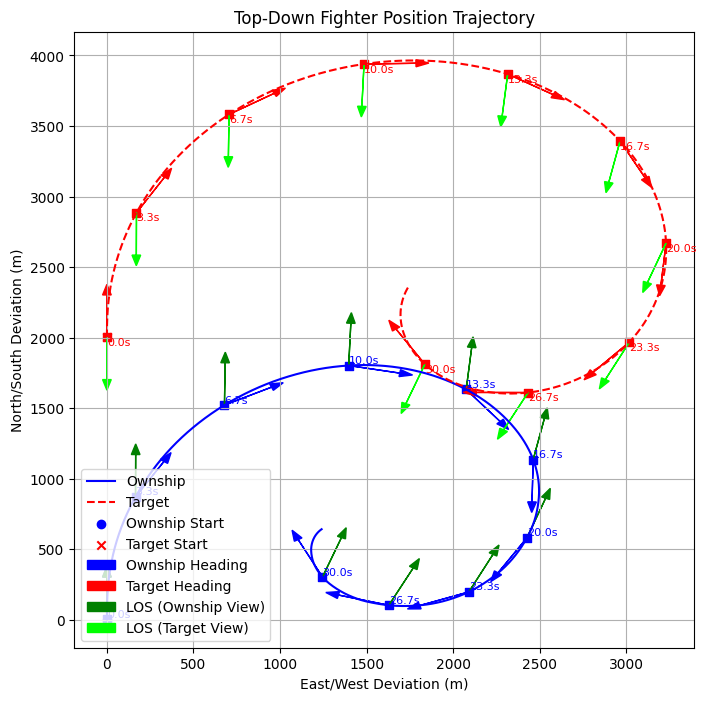

In [35]:
for step in [50000, 100000, 150000, 200000, 250000]:
    testEnvironment(model_path=f"./f16_leadpursuit_checkpoints/f16_lead_pursuit_{step}_steps.zip", time_in_seconds=True)
step = 50000
for i in range(5):
    testEnvironment(model_path=f"./f16_leadpursuit_checkpoints/f16_lead_pursuit_250k_no_fcs_250k_with_fcs_{step}_steps.zip", time_in_seconds=True)
    step += 50000

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_after_150k_no_fcs_200000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       

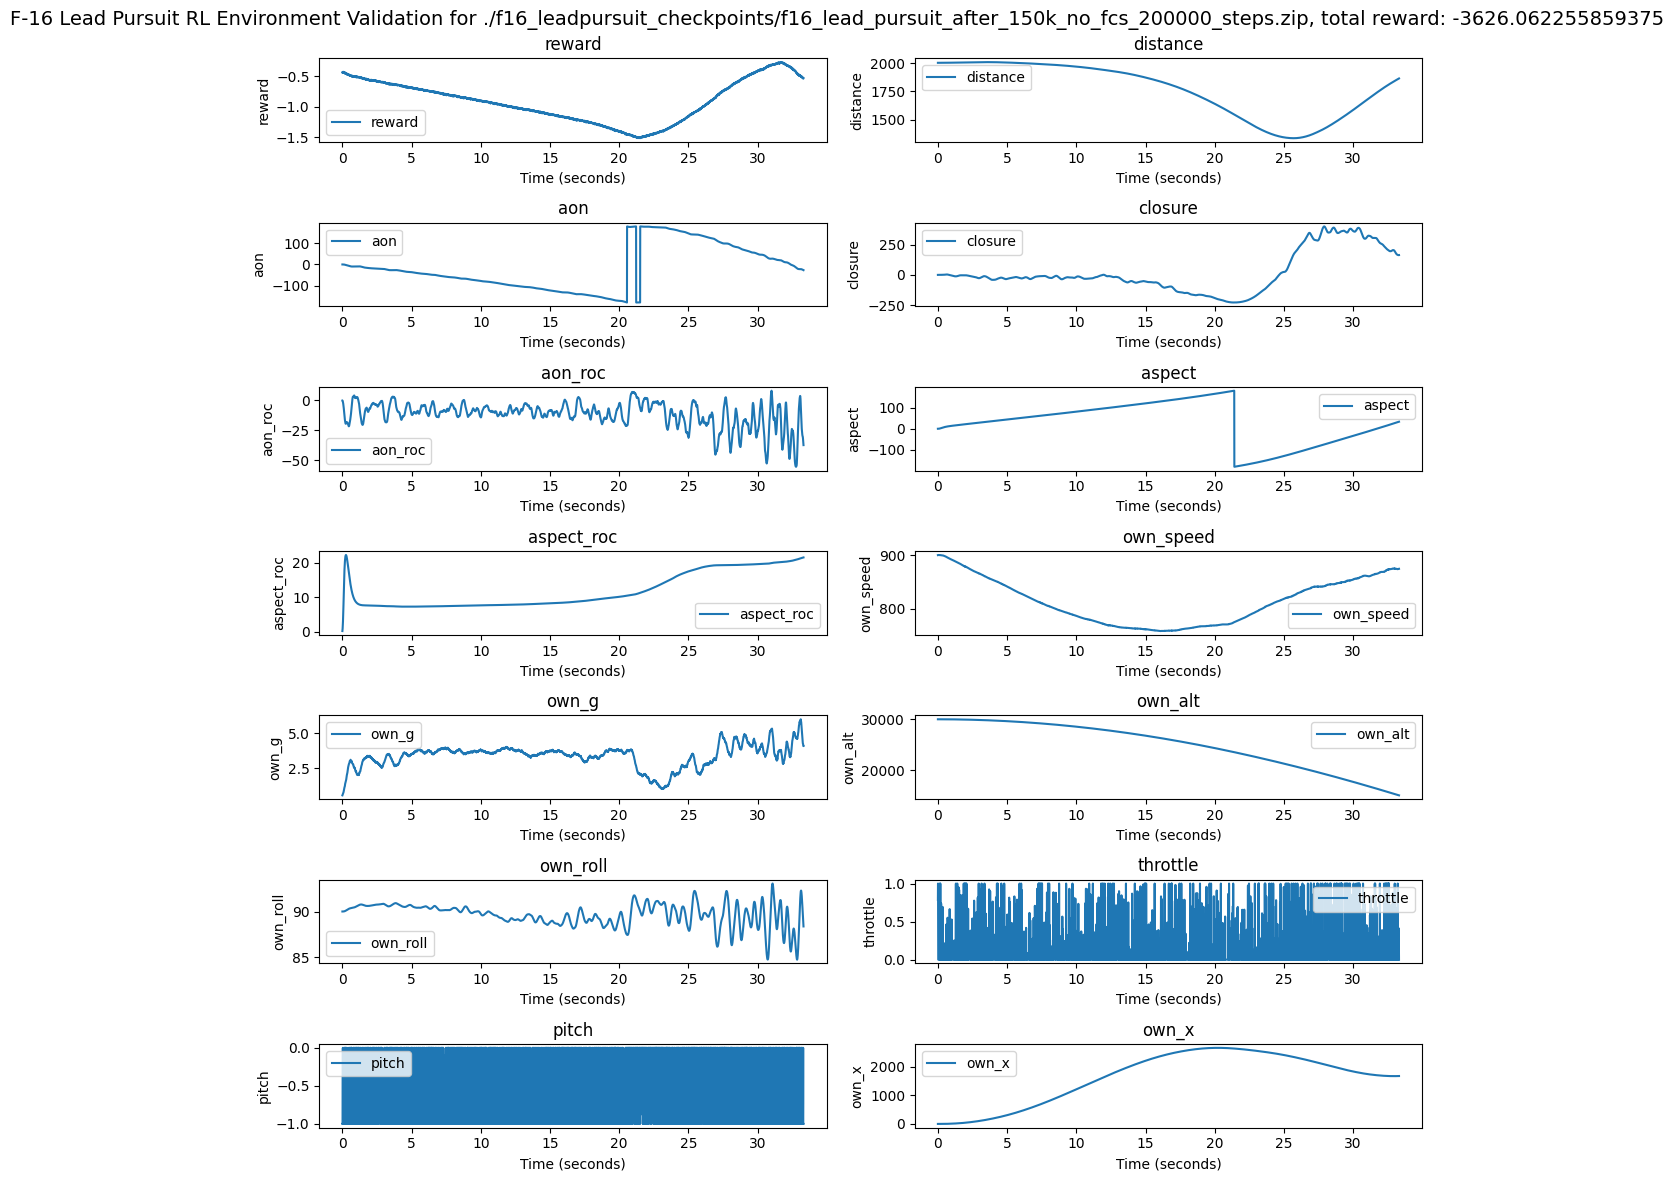

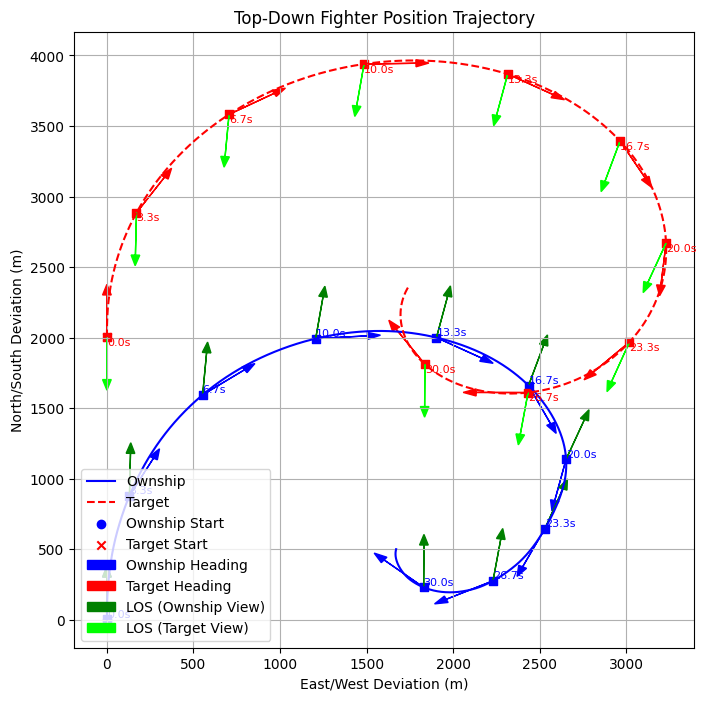

loaded model:  ./f16_leadpursuit_checkpoints/f16_lead_pursuit_after_150k_no_fcs_250000_steps.zip
Setting initial conditions for both aircraft...
Initial conditions set. Starting simulation...
initial observation [ 2.0035122e+03  1.2562396e-11 -3.9175092e-03  1.5080907e-09
 -1.2562396e-11 -1.5080907e-09  9.0006354e+02  5.5097091e-01]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       

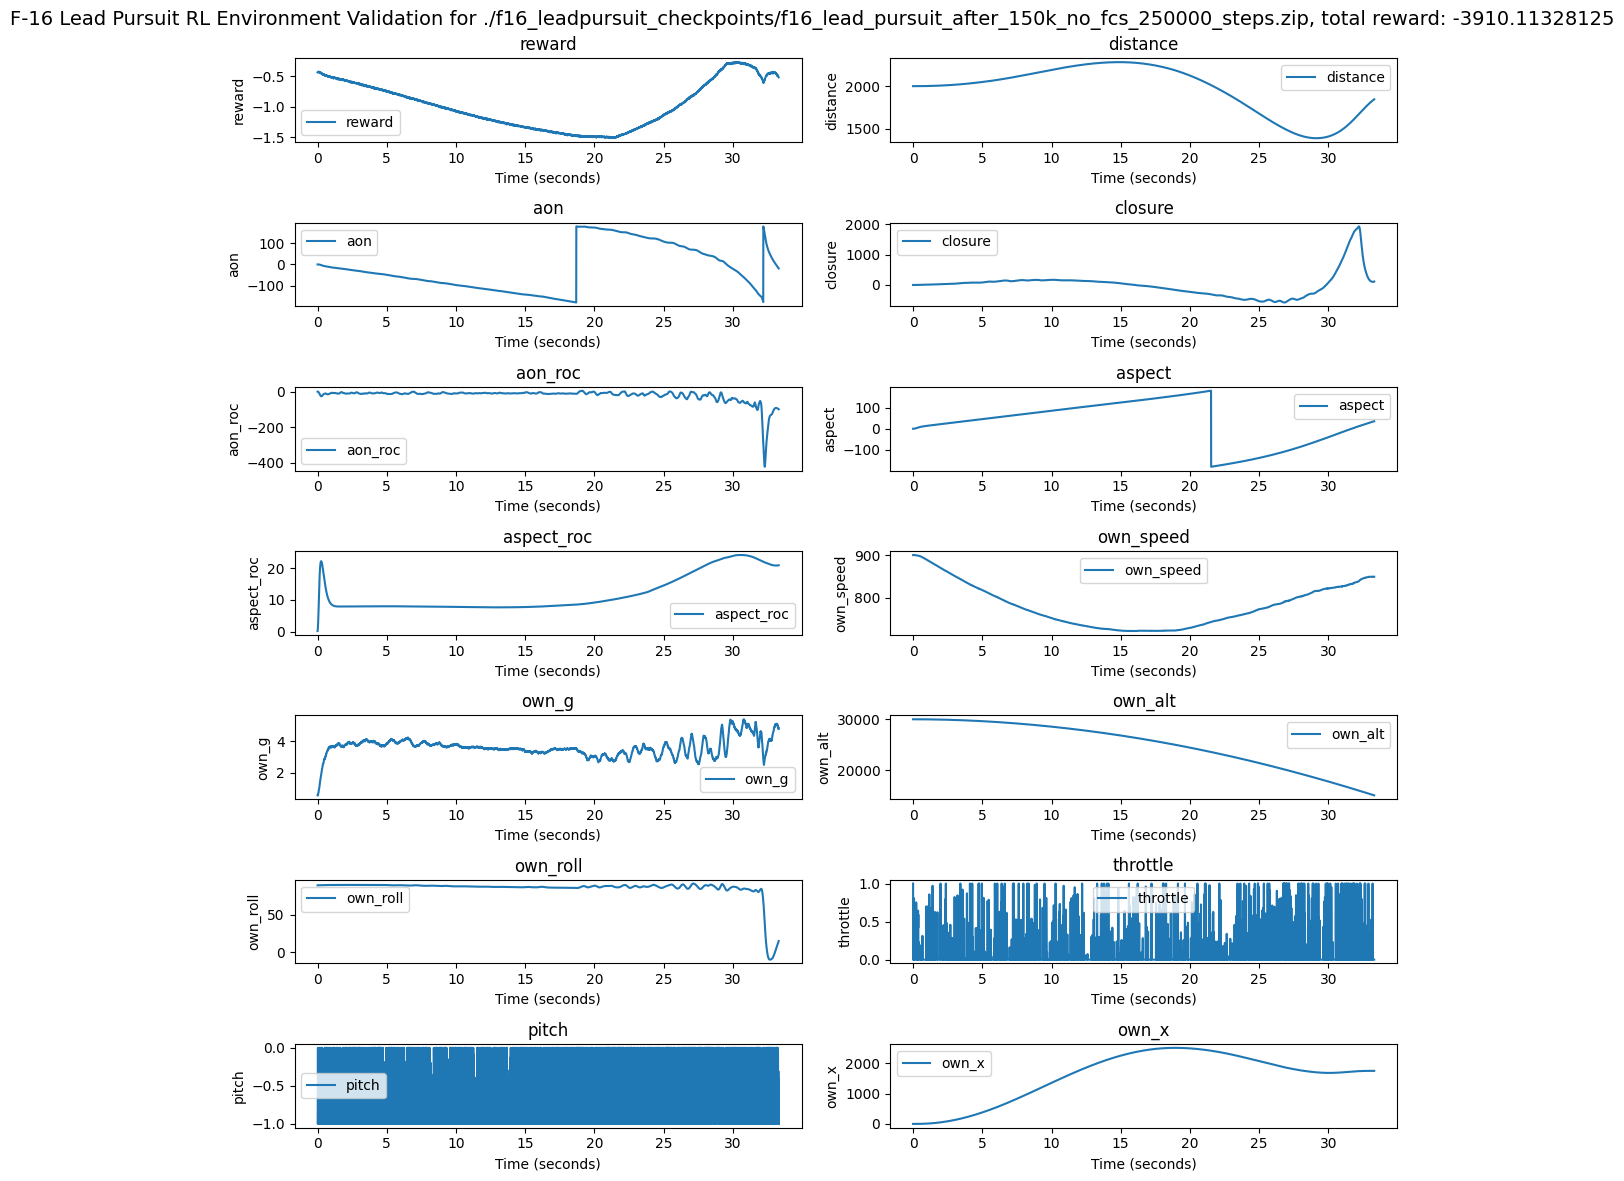

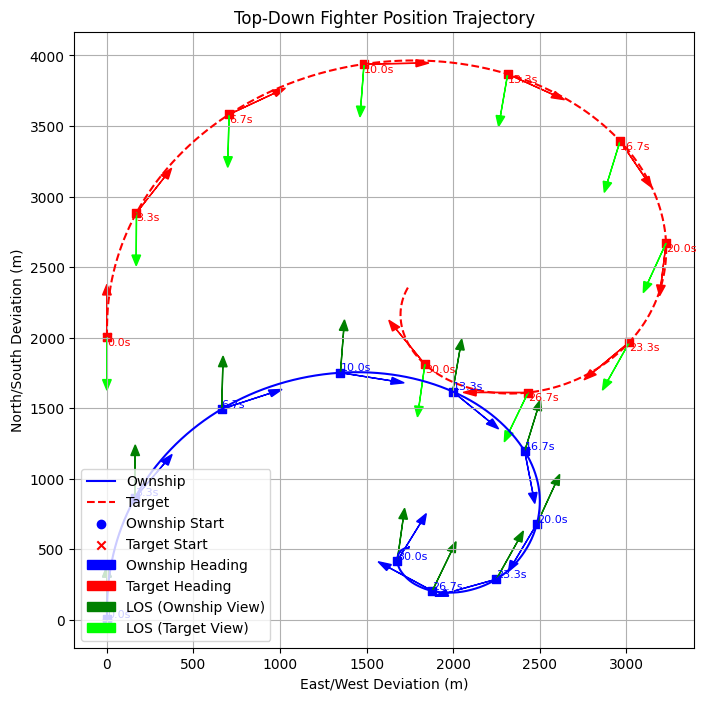

In [39]:
for step in [200000, 250000]:
    testEnvironment(model_path=f"./f16_leadpursuit_checkpoints/f16_lead_pursuit_after_150k_no_fcs_{step}_steps.zip", time_in_seconds=True)